In [ ]:
import numpy as np
import matplotlib.pylab as plt
import h5py

import random
import requests

from pathlib import Path

from sklearn.model_selection import train_test_split

from scipy.stats import pearsonr

from pycbc.waveform import get_td_waveform

from gwpy.timeseries import TimeSeries as TS
from gwpy.signal import filter_design

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras


# Data List

In [2]:
def fetch_strain_list(run, detector, gps_start, gps_end):
    "Return the list of strain file info for `run` and `detector`."

    # Get the strain list
    fetch_url = (
        f"https://gwosc.org/archive/links/"
        f"{run}/{detector}/{gps_start}/{gps_end}/json/"
    )
    response = requests.get(fetch_url)
    response.raise_for_status()
    return response.json()["strain"]

In [3]:
strain_files = fetch_strain_list("O2_4KHZ_R1", "H1", 1164556817, 1187733618)
print(f"Found {len(strain_files)} files")

for file in strain_files:
    print(file)

Found 7408 files
{'GPSstart': 1164558336, 'UTCstart': '2016-11-30T16:25:19', 'detector': 'H1', 'sampling_rate': 4096, 'duration': 4096, 'format': 'hdf5', 'url': 'https://gwosc.org/archive/data/O2_4KHZ_R1/1163919360/H-H1_GWOSC_O2_4KHZ_R1-1164558336-4096.hdf5', 'min_strain': -3.1019033457153e-18, 'max_strain': 3.02943732524251e-18, 'mean_strain': 6.69304089303538e-23, 'stdev_strain': 7.8643189466378e-19, 'duty_cycle': 32.861328125, 'BLRMS200': 7.3726049668073e-24, 'BLRMS1000': 5.14539103599039e-21, 'BNS': 68.9855759338639}
{'GPSstart': 1164558336, 'UTCstart': '2016-11-30T16:25:19', 'detector': 'H1', 'sampling_rate': 4096, 'duration': 4096, 'format': 'gwf', 'url': 'https://gwosc.org/archive/data/O2_4KHZ_R1/1163919360/H-H1_GWOSC_O2_4KHZ_R1-1164558336-4096.gwf', 'min_strain': -3.1019033457153e-18, 'max_strain': 3.02943732524251e-18, 'mean_strain': 6.69304089303538e-23, 'stdev_strain': 7.8643189466378e-19, 'duty_cycle': 32.861328125, 'BLRMS200': 7.3726049668073e-24, 'BLRMS1000': 5.1453910359

In [4]:
len(strain_files)

7408

In [5]:
good_files=[file for file in strain_files if ((file['duty_cycle']==100.0) & (file["format"] == "hdf5"))]

In [6]:
len(good_files)

2779

In [ ]:
random.seed(10)
random_samples=random.sample(good_files,50)

# Download Data

In [ ]:
def download_strain_file(download_url):

    filename = "./strain_data/"+download_url.split("/")[-1]
    with requests.get(download_url, stream=True) as r:
        r.raise_for_status()
        with open(filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
    return filename


for a_file in random_samples:
    print(f"Downloading {a_file['url']}")
    fname = download_strain_file(a_file["url"])

'def download_strain_file(download_url):\n    "Download the strain file on the given url and save to disk."\n    # In the next line I parse the file name from the download url.\n    # Ideally, the file name should be grabbed from the\n    # Content-Disposition response header.\n    filename = "./strain_data/"+download_url.split("/")[-1]\n    with requests.get(download_url, stream=True) as r:\n        r.raise_for_status()\n        with open(filename, "wb") as f:\n            for chunk in r.iter_content(chunk_size=8192):\n                f.write(chunk)\n    return filename\n\n\nfor a_file in random_samples:\n    print(f"Downloading {a_file[\'url\']}")\n    fname = download_strain_file(a_file["url"])'

# File Exploration

In [ ]:
directory = Path('./strain_data') 

archivos={}

for file in directory.iterdir():  
    if file.is_file(): 
        filename=file.__str__()
        print(filename)
        archivos[filename]=h5py.File(filename, 'r')


strain_data/H-H1_GWOSC_O2_4KHZ_R1-1181847552-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1176776704-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1184206848-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1171046400-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1181880320-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1169514496-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1181339648-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1166438400-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1186877440-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1170276352-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1177657344-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1184686080-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1177939968-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1166336000-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1171095552-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1186918400-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1176539136-4096.hdf5
strain_data/H-H1_GWOSC_O2_4KHZ_R1-1168891904-4096.hdf5
strain_dat

In [3]:
test_file_name=next(iter(archivos.keys()))
test_file=archivos[test_file_name]
test_file_name

'strain_data/H-H1_GWOSC_O2_4KHZ_R1-1181847552-4096.hdf5'

In [4]:
print(test_file.keys())

<KeysViewHDF5 ['meta', 'quality', 'strain']>


In [ ]:

strain = test_file['strain']['Strain']
ts = test_file['strain']['Strain'].attrs['Xspacing']
print(f"ts = {ts}s, sample rate = {1/ts}Hz")

ts = 0.000244140625s, sample rate = 4096.0Hz


In [ ]:

metaKeys = test_file['meta'].keys()
for key in metaKeys:
    print(key, test_file['meta'][key])

meta={}
times={}
for key in archivos.keys():
    meta[key]=archivos[key]['meta']
    gpsStart = meta[key]['GPSstart'][()]
    duration = meta[key]['Duration'][()]
    gpsEnd   = gpsStart + duration
    times[key] = np.arange(gpsStart, gpsEnd, ts)


Description <HDF5 dataset "Description": shape (), type "|O">
DescriptionURL <HDF5 dataset "DescriptionURL": shape (), type "|O">
Detector <HDF5 dataset "Detector": shape (), type "|O">
Duration <HDF5 dataset "Duration": shape (), type "<i8">
FrameType <HDF5 dataset "FrameType": shape (), type "|O">
GPSstart <HDF5 dataset "GPSstart": shape (), type "<i8">
Observatory <HDF5 dataset "Observatory": shape (), type "|O">
StrainChannel <HDF5 dataset "StrainChannel": shape (), type "|O">
Type <HDF5 dataset "Type": shape (), type "|O">
UTCstart <HDF5 dataset "UTCstart": shape (), type "|O">


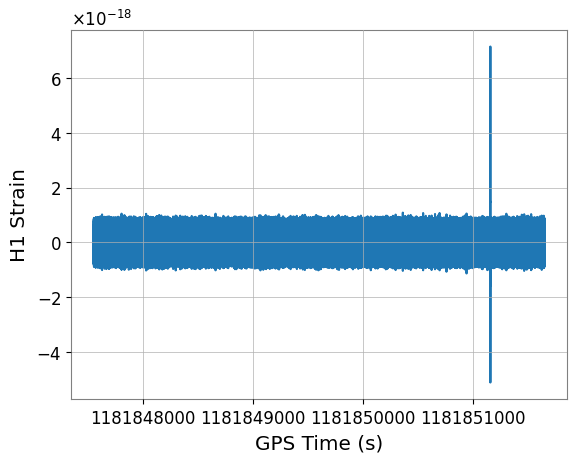

In [ ]:

from matplotlib.ticker import ScalarFormatter

plt.plot(times[test_file_name], strain[()])
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)

plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

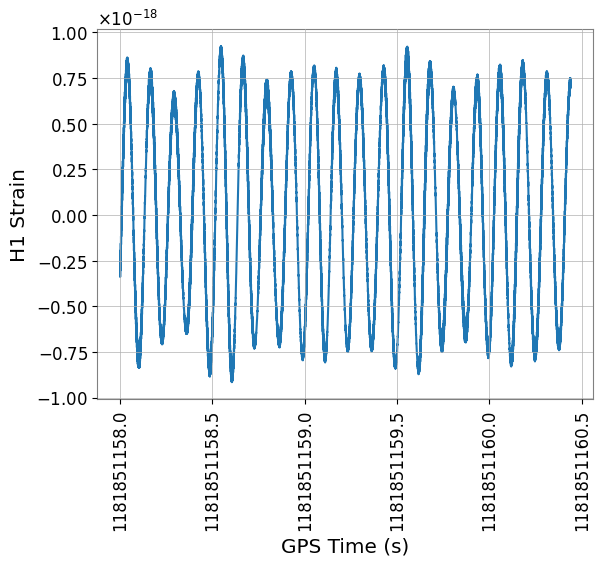

In [ ]:

numsamples = 10000
startTime  = 1181851158.0
startIndex = np.min(np.nonzero(startTime < times[test_file_name]))
time_seg   = times[test_file_name][startIndex:(startIndex+numsamples)]
strain_seg = strain[startIndex:(startIndex+numsamples)]
plt.plot(time_seg, strain_seg,)
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)

plt.xticks(rotation=90)

plt.gca().xaxis.set_major_formatter(formatter)

plt.show()

In [9]:
def dump_info(name, obj):
    print("{0} :".format(name))
    try:
        print("   value: {0}".format(str(obj[()])))
        for key in obj.attrs.keys():
            print("     attrs[{0}]:  {1}".format(key, obj.attrs[key]))
    except:
        pass

file = test_file
file.visititems(dump_info)

meta :
meta/Description :
   value: b'Strain data time series from LIGO'
meta/DescriptionURL :
   value: b'http://www.gw-openscience.org/'
meta/Detector :
   value: b'H1'
meta/Duration :
   value: 4096
meta/FrameType :
   value: b'H1_CLEANED_HOFT_C02'
meta/GPSstart :
   value: 1181847552
meta/Observatory :
   value: b'H'
meta/StrainChannel :
   value: b'H1:DCH-CLEAN_STRAIN_C02'
meta/Type :
   value: b'StrainTimeSeries'
meta/UTCstart :
   value: b'2017-06-18T18:58:54'
quality :
quality/detail :
quality/injections :
quality/injections/GWOSCmeta :
   value: b'GWOSC-4KHZ_R1_INJMASK'
quality/injections/InjDescriptions :
   value: [b'no cbc injection' b'no burst injections'
 b'no detchar injections' b'no continuous wave injections'
 b'no stoch injections']
quality/injections/InjShortnames :
   value: [b'NO_CBC_HW_INJ' b'NO_BURST_HW_INJ' b'NO_DETCHAR_HW_INJ'
 b'NO_CW_HW_INJ' b'NO_STOCH_HW_INJ']
quality/injections/Injmask :
   value: [23 23 23 ... 23 23 23]
     attrs[Bits]:  5
     attrs[Desc

# Data Quality

In [10]:
injection_info={}
quality_info={}

injection_masks={}
quality_masks={}

for key in archivos.keys():
    quality_info[key] = archivos[key]['quality']['simple']
    quality_masks[key] = quality_info[key]['DQmask'][()]
    injection_info[key] = archivos[key]['quality']['injections']
    injection_masks[key] = injection_info[key]['Injmask'][()]



bitnameList = quality_info[test_file_name]['DQShortnames'][()]
descriptionList = quality_info[test_file_name]['DQDescriptions'][()]
nbits = len(bitnameList)

for bit in range(nbits):
    print(f"Channel #{bit} ({bitnameList[bit].decode()}): {descriptionList[bit].decode()}")

bitnameListInj = injection_info[test_file_name]['InjShortnames'][()]
descriptionListInj = injection_info[test_file_name]['InjDescriptions'][()]
nbitsinj = len(bitnameListInj)

for bit in range(nbitsinj):
    print(f"Channel #{bit} ({bitnameListInj[bit].decode()}): {descriptionListInj[bit].decode()}")

Channel #0 (DATA): data present
Channel #1 (CBC_CAT1): passes the cbc CAT1 test
Channel #2 (CBC_CAT2): passes cbc CAT2 test
Channel #3 (CBC_CAT3): passes cbc CAT3 test
Channel #4 (BURST_CAT1): passes burst CAT1 test
Channel #5 (BURST_CAT2): passes burst CAT2 test
Channel #6 (BURST_CAT3): passes burst CAT3 test
Channel #0 (NO_CBC_HW_INJ): no cbc injection
Channel #1 (NO_BURST_HW_INJ): no burst injections
Channel #2 (NO_DETCHAR_HW_INJ): no detchar injections
Channel #3 (NO_CW_HW_INJ): no continuous wave injections
Channel #4 (NO_STOCH_HW_INJ): no stoch injections


In [ ]:
value = quality_masks[test_file_name][2400]
print("Value in decimal: {0}".format(value))
print("Same value in binary (with 7 bits): {0:#09b}".format(value))
value_inj=injection_masks[test_file_name][2400]
print("Value in decimal: {0}".format(value_inj))
print("Same value in binary (with 7 bits): {0:#07b}".format(value_inj))

Value in decimal: 127
Same value in binary (with 7 bits): 0b1111111
Value in decimal: 23
Same value in binary (with 7 bits): 0b10111


In [12]:
final_masks={}

for key in archivos.keys():    
    quality_masks[key] = np.array([v==127 for v in quality_masks[key]])
    injection_masks[key]=np.array([v==23 for v in injection_masks[key]])
    
    final_masks[key]=np.multiply(quality_masks[key], injection_masks[key])

In [13]:
segmentos_validos={}
for key in archivos.keys():
    gpsStart=meta[key]['GPSstart'][()]
    dummy = np.zeros(final_masks[key].shape)
    masked_dummy = np.ma.masked_array(dummy, np.logical_not(final_masks[key]))
    segments = np.ma.flatnotmasked_contiguous(masked_dummy)
    segList = [(int(seg.start+gpsStart), int(seg.stop+gpsStart)) for seg in segments]
    segmentos_validos[key]=segList
    print(segList)

[(1181847552, 1181848951), (1181848953, 1181849236), (1181849239, 1181849259), (1181849260, 1181851154), (1181851158, 1181851648)]
[(1176776704, 1176780139), (1176780140, 1176780691), (1176780692, 1176780710), (1176780714, 1176780762), (1176780770, 1176780771), (1176780775, 1176780779), (1176780780, 1176780800)]
[(1184206848, 1184207661), (1184207665, 1184207957), (1184207959, 1184207962), (1184207964, 1184208059), (1184208063, 1184209072), (1184209074, 1184209442), (1184209444, 1184209445), (1184209450, 1184209456), (1184209458, 1184210940), (1184210942, 1184210944)]
[(1171046400, 1171047090), (1171047094, 1171048385), (1171048389, 1171050496)]
[(1181880320, 1181880937), (1181880941, 1181884111), (1181884114, 1181884416)]
[(1169514496, 1169518592)]
[(1181339648, 1181340309), (1181340310, 1181343744)]
[(1166438400, 1166442496)]
[(1186877440, 1186881536)]
[(1170276352, 1170278607), (1170278610, 1170280448)]
[(1177657344, 1177659865), (1177659869, 1177661349), (1177661350, 1177661440)]
[

In [14]:
eventos=[1126259462.4,
1128678900.4,
1135136350.6,
1167559936.6,
1180922494.5,
1185389807.3,
1186302519.8,
1186741861.5,
1187008882.4,
1187058327.1,
1187529256.5]

def filtrar_eventos(eventos,segmento):
    return np.all([(segmento<evento-308)|(segmento>evento+300) for evento in eventos])


In [21]:
downsampled_strains={}
psd_dict={}
for key in archivos.keys():
    downsampled_strains[key]=archivos[key]['strain']['Strain']
frequency=4096

In [22]:
def divide_segment(gps_start,frequency,start, end, length,eventos):
    segments = []
    current = (start-gps_start)*frequency
    current_time=start
    while current + length*frequency <= (end-gps_start)*frequency:
        if filtrar_eventos(eventos,current_time):
            segments.append((current, current + length*frequency))
        current += length*frequency
        current_time+=length
    return segments

In [24]:
segmentos_validos_indices={}
for key in archivos.keys():
    segmentos_divididos=[]
    for seg in segmentos_validos[key]:
        segmentos_divididos+=divide_segment(meta[key]['GPSstart'][()],frequency,seg[0],seg[1],8,eventos)
    segmentos_validos_indices[key]=segmentos_divididos
    

In [25]:
sum([len(segmentos_validos_indices[key]) for key in archivos.keys()])

25261

In [26]:
len(segmentos_validos_indices[test_file_name])

508

In [27]:
segmentos_validos_indices[test_file_name]

[(np.int64(0), np.int64(32768)),
 (np.int64(32768), np.int64(65536)),
 (np.int64(65536), np.int64(98304)),
 (np.int64(98304), np.int64(131072)),
 (np.int64(131072), np.int64(163840)),
 (np.int64(163840), np.int64(196608)),
 (np.int64(196608), np.int64(229376)),
 (np.int64(229376), np.int64(262144)),
 (np.int64(262144), np.int64(294912)),
 (np.int64(294912), np.int64(327680)),
 (np.int64(327680), np.int64(360448)),
 (np.int64(360448), np.int64(393216)),
 (np.int64(393216), np.int64(425984)),
 (np.int64(425984), np.int64(458752)),
 (np.int64(458752), np.int64(491520)),
 (np.int64(491520), np.int64(524288)),
 (np.int64(524288), np.int64(557056)),
 (np.int64(557056), np.int64(589824)),
 (np.int64(589824), np.int64(622592)),
 (np.int64(622592), np.int64(655360)),
 (np.int64(655360), np.int64(688128)),
 (np.int64(688128), np.int64(720896)),
 (np.int64(720896), np.int64(753664)),
 (np.int64(753664), np.int64(786432)),
 (np.int64(786432), np.int64(819200)),
 (np.int64(819200), np.int64(851968)

In [29]:
len(downsampled_strains[test_file_name])

16777216

In [30]:
ruidos=np.empty((0,8*frequency))
n=0
for key in archivos.keys():
    current_strain=downsampled_strains[key]
    segmented_strain=[current_strain[start:end] for start, end in segmentos_validos_indices[key]]
    n+=1
    print(n)
    ruidos=np.concatenate((ruidos,np.stack(segmented_strain)),axis=0)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [31]:
ruidos.shape

(25261, 32768)

In [32]:
np.save('ruidos_procesados.npy',ruidos)

# Inyección de Señales

In [2]:
ruidos=np.load('ruidos_procesados.npy')

In [3]:
ruidos_cs, ruidos_ss = train_test_split(ruidos,test_size=0.5,random_state=42)

In [4]:
ruidos_cs.shape,ruidos_ss.shape

((12630, 32768), (12631, 32768))

In [26]:
def pad(hp,target_len = 4096):

    proporcion = 0.5
    
    hp=np.array(hp)

    if hp.size < target_len:
        padded=np.hstack((np.zeros(int((target_len - hp.size)*proporcion)),hp))
        padded = np.pad(padded, (0, target_len - padded.size), mode='constant')
    else:
        padded = hp[-target_len:]

    return TS(padded,dt=1.0/4096)


In [27]:
def generate_waveform(mass1=30, mass2=30):
    try:
        hp, _ = get_td_waveform(approximant="SEOBNRv4_opt",
                            mass1=mass1, mass2=mass2,
                            delta_t=1.0 / 4096,
                            f_lower=30)
    except:
        return generate_waveform(mass1=mass1+0.5, mass2=mass2)
    
    return TS(hp,dt=1.0/4096).taper()

In [28]:
prueba=generate_waveform(mass1=30,mass2=30)

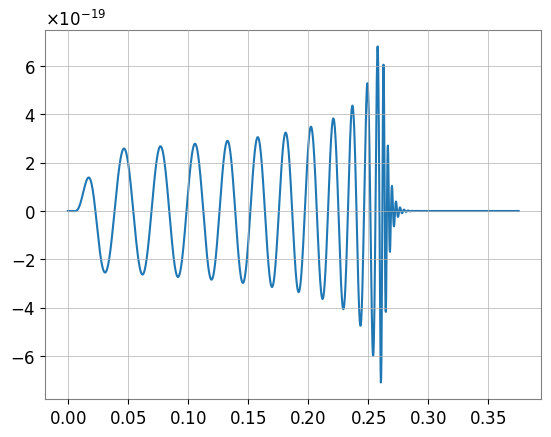

In [29]:
plt.plot(prueba)

In [30]:
prueba_ruido=TS(ruidos_cs[7],dt=1.0/4096)

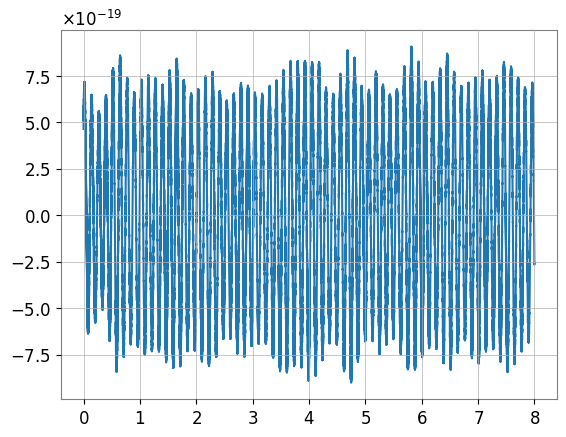

In [31]:
plt.plot(prueba_ruido)

# Whitening

In [84]:
psd = prueba_ruido.psd(2, overlap=0,
                    method='median', window='hann')

psd_1 = psd.interpolate(1./prueba_ruido.duration.decompose().value)
psd_2 = psd.interpolate(1./prueba.duration.decompose().value)


In [85]:
psd.shape,psd_1.shape, psd_2.shape

((4097,), (16385,), (770,))

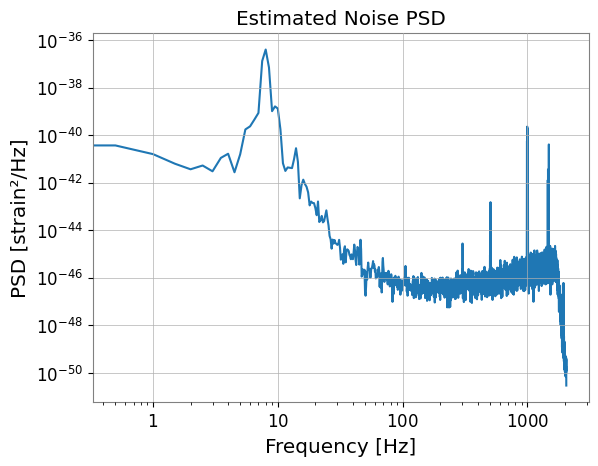

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

ax.plot(psd)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [strain²/Hz]')
ax.set_title('Estimated Noise PSD')

plt.show()

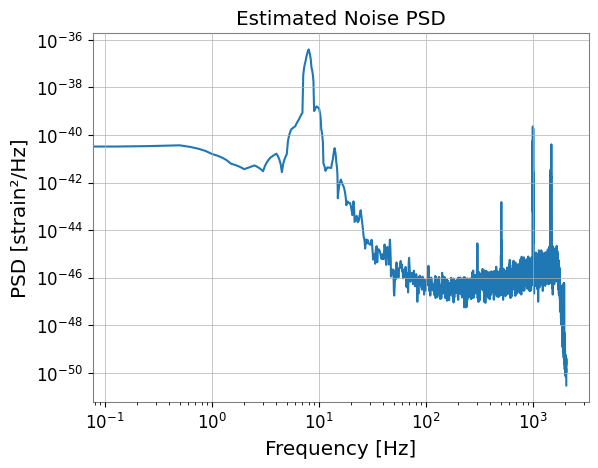

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

ax.plot(psd_1)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [strain²/Hz]')
ax.set_title('Estimated Noise PSD')

plt.show()

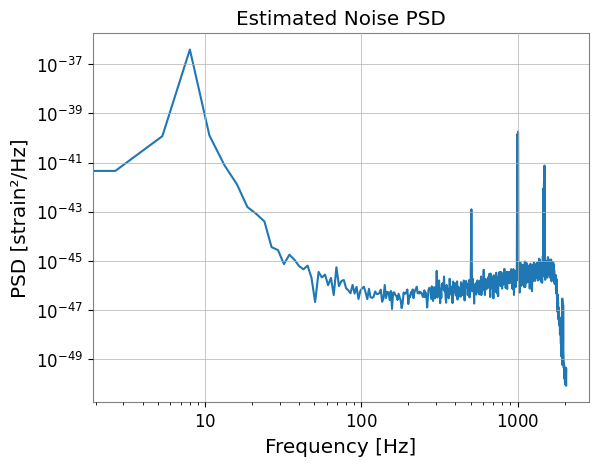

In [ ]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

ax.plot(psd_2)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD [strain²/Hz]')
ax.set_title('Estimated Noise PSD')

plt.show()

In [32]:
def whiten_noise_signal(noise,signal,overlap=0, method='median', window='hann',detrend='constant',
                        fduration_noise=2,fftlength = 2):
                            
    asd = noise.asd(fftlength, overlap=overlap,
                    method=method, window=window)
    
    psd= noise.psd(fftlength, overlap=overlap,
                    method=method, window=window)
    
    asd_2 = asd.interpolate(1./signal.duration.decompose().value)
    asd_3 = asd.interpolate(1./noise.duration.decompose().value)

    ncorner = 0

    ntaps_noise = int((fduration_noise * noise.sample_rate).decompose().value)
    ntaps_signal = int((((len(signal)//2)* 2 * (1.0/4096)) * signal.sample_rate).decompose().value)

    tdw_signal = filter_design.fir_from_transfer(1/asd_2.value, ntaps=ntaps_signal, 
                                            window=window, ncorner=ncorner)
    tdw_noise = filter_design.fir_from_transfer(1/asd_3.value, ntaps=ntaps_noise, 
                                            window=window, ncorner=ncorner)
    
    in_signal = signal.copy().detrend(detrend)
    in_noise = noise.copy().detrend(detrend)

    out_signal = in_signal.convolve(tdw_signal, window=window) * np.sqrt(2 * in_signal.dt.decompose().value)
    out_noise = in_noise.convolve(tdw_noise, window=window) * np.sqrt(2 * in_noise.dt.decompose().value)

    return out_signal, out_noise, psd

In [33]:
prueba_whitened,prueba_ruido_whitened,_ = whiten_noise_signal(prueba_ruido, prueba)

In [34]:
len(prueba_whitened)

1539

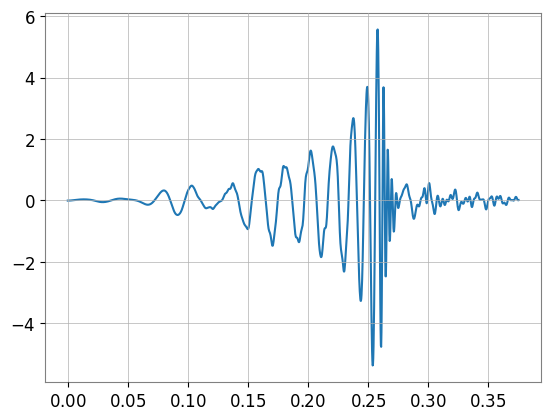

In [35]:
plt.plot(prueba_whitened.bandpass(20,500)/np.std(prueba_whitened.bandpass(20,500)))

(3.8, 4.1)

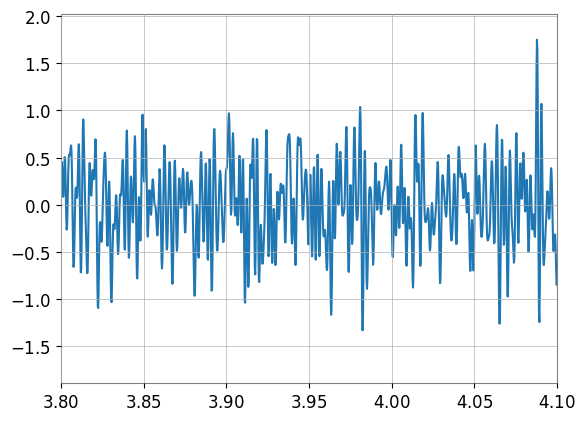

In [24]:
plt.plot(prueba_ruido_whitened.bandpass(20,500))
plt.xlim(4-0.2,4+0.1)

(3.8, 4.1)

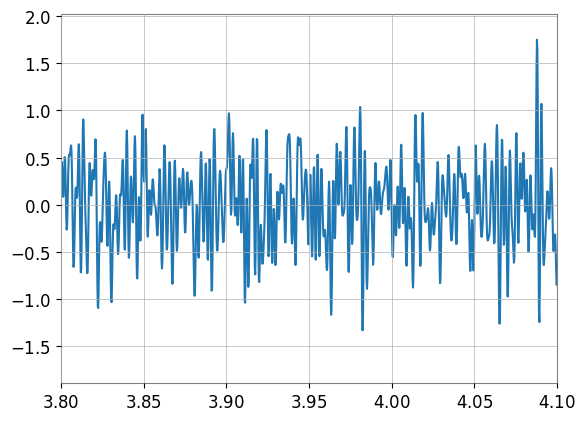

In [36]:
plt.plot(prueba_ruido.whiten().bandpass(20,500))
plt.xlim(4-0.2,4+0.1)

In [37]:
def inject_wave(ruido,señal,target_snr):

    signal,noise,psd = whiten_noise_signal(ruido,señal)

    noise = noise.bandpass(20.0,500.0)
    signal = signal.bandpass(20.0,500.0)

    signal=signal / np.std(signal)

    power_signal=np.mean(signal**2)
    power_noise=np.mean(noise**2)


    scaling_factor=np.sqrt(target_snr/ (power_signal / power_noise))

    scaled_signal = scaling_factor * signal

    padded_scaled_signal=pad(scaled_signal)
    padded_signal=pad(signal)

    injected=noise[4*4096-2048:4*4096+2048]+padded_scaled_signal
    
    return  injected, signal, padded_signal, padded_scaled_signal, psd

def whiten_noise(ruido):

    ruido=ruido.whiten().bandpass(20.0,500.0)

    ruido=ruido[4*4096-2048:4*4096+2048]

    return ruido

def standardize(signal):
    whitened_signal_min = np.min(signal)
    whitened_signal_max = np.max(signal)
    whitened_signal_normalized = (signal - whitened_signal_min) / (whitened_signal_max - whitened_signal_min)

    return whitened_signal_normalized



In [40]:
suma, señal_corta_normalizada,señal_larga_normalizada,señal_larga_escalada,psd=inject_wave(prueba_ruido,prueba,1)

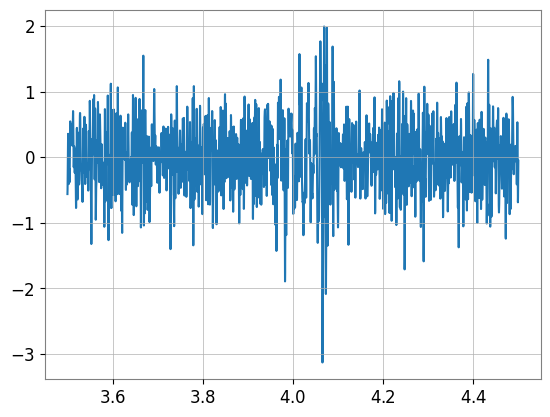

In [41]:
plt.plot(suma)

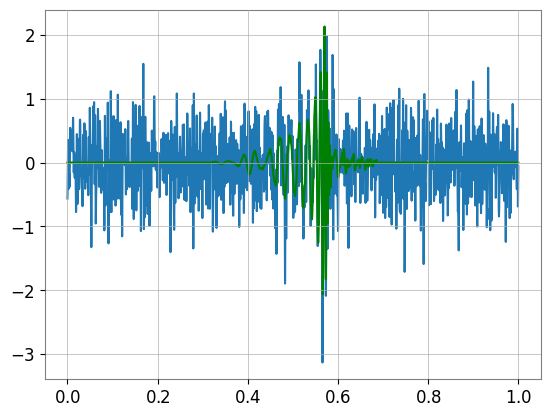

In [ ]:
x_values=[x*(1/4096) for x in range(len(suma))]

plt.plot(x_values,suma)
plt.plot(x_values,señal_larga_escalada,color='green')


(0.4, 0.6)

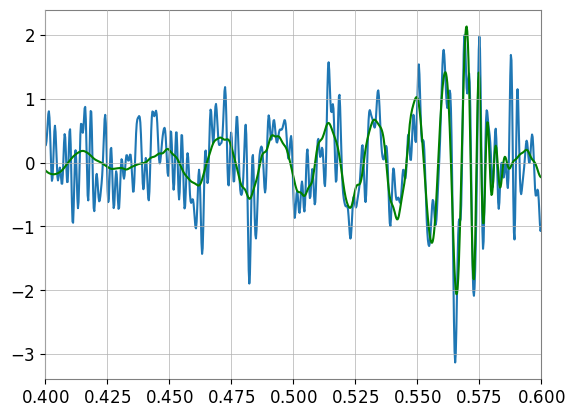

In [ ]:
x_values=[x*(1/4096) for x in range(len(suma))]

plt.plot(x_values,suma)
plt.plot(x_values,señal_larga_escalada,color='green')

plt.xlim(0.4,0.6)

In [ ]:
x_min, x_max = 10, 60
y_min, y_max = 10, 60
z_min, z_max = 0.01, 1

n_samples = ruidos_cs.shape[0]

x = np.random.uniform(x_min, x_max, n_samples).round(1)
y = np.random.uniform(y_min, y_max, n_samples).round(1)
z = np.random.uniform(z_min,z_max,n_samples).round(1)
w = np.ones(n_samples)

parameters = np.stack((x, y, z, w), axis=1)

In [45]:
np.save('parameters.npy',parameters)

In [9]:
parameters=np.load('parameters.npy')

In [46]:
ruidos_ss[0].shape

(32768,)

In [47]:
senales_limpias=np.empty((0,4096))
ruidos_inyectados=np.empty((0,4096))
senales_normalizadas=np.empty((0,4096))

for index,par in enumerate(parameters):
    if index%100==0: print(index)
    senal=generate_waveform(mass1=par[0],mass2=par[1])
    ruido_inyectado = TS(ruidos_cs[index],dt=1.0/4096)
    suma,_,señal_larga_normalizada,señal_larga_escalada,_ = inject_wave(ruido_inyectado,senal,par[2])
    senal_limpia=[señal_larga_escalada]
    senal_normalizada=[señal_larga_normalizada]
    ruido_inyectado = [suma]

    senales_limpias=np.vstack((senales_limpias,senal_limpia))
    ruidos_inyectados=np.vstack((ruidos_inyectados,ruido_inyectado))
    senales_normalizadas=np.vstack((senales_normalizadas,senal_normalizada))




0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600


In [48]:
np.save('senales_limpias.npy',senales_limpias)
np.save('ruidos_inyectados.npy',ruidos_inyectados)
np.save('senales_normalizadas.npy',senales_normalizadas)

In [49]:
ruidos_sin_senal=np.empty((0,4096))

for index,ruido in enumerate(ruidos_ss):
    if index%100==0: print(index)
    ruido_sin_senal = TS(ruido,dt=1.0/4096)
    ruido_sin_senal = [whiten_noise(ruido_sin_senal)]

    ruidos_sin_senal=np.vstack((ruidos_sin_senal,ruido_sin_senal))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600


In [50]:
np.save('ruidos_sin_senal.npy',ruidos_sin_senal)

In [2]:
señales_limpias=np.load('senales_limpias.npy')
ruidos_inyectados=np.load('ruidos_inyectados.npy')
ruidos_sin_señal=np.load('ruidos_sin_senal.npy')

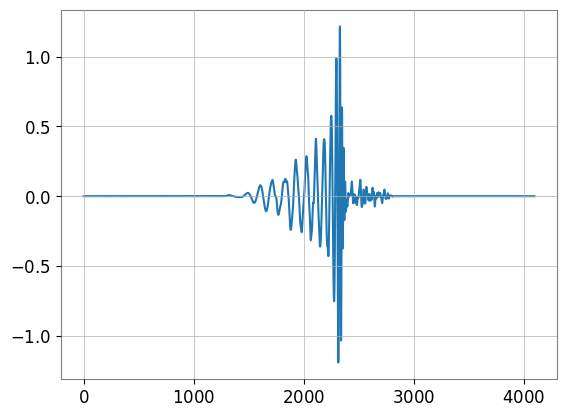

In [51]:
plt.plot(senales_limpias[0])

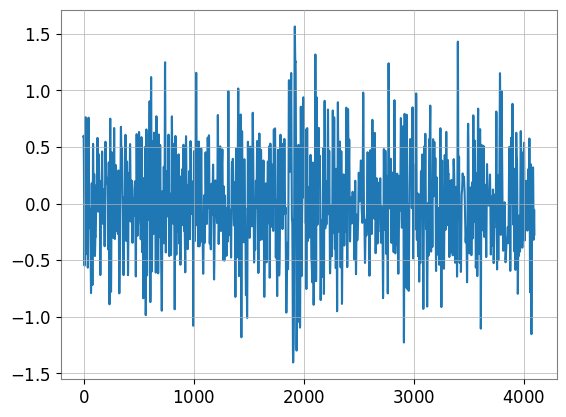

In [66]:
plt.plot(ruidos_inyectados[0])

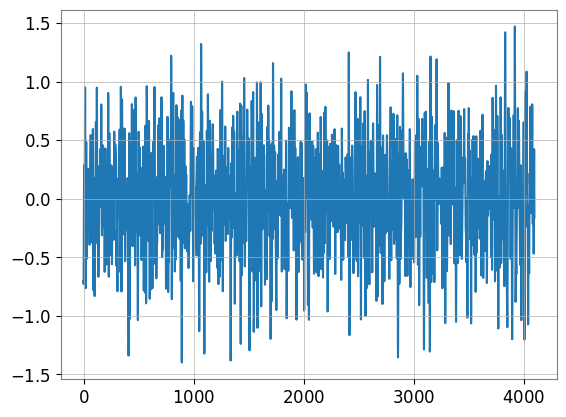

In [52]:
plt.plot(ruidos_sin_senal[0])

In [53]:
senales_vacias=[np.zeros(ruidos_sin_senal[0].shape[0]) for i in range(ruidos_sin_senal.shape[0])]

señales=np.vstack((senales_limpias,senales_vacias))

ruidos=np.vstack((ruidos_inyectados,ruidos_sin_senal))

In [54]:
señales=señales[...,np.newaxis]
ruidos=ruidos[...,np.newaxis]

In [55]:
ruidos.shape, señales.shape

((25261, 4096, 1), (25261, 4096, 1))

In [56]:
np.save('señales.npy',señales)
np.save('ruidos.npy',ruidos)

In [2]:
señales=np.load('señales.npy')
ruidos=np.load('ruidos.npy')

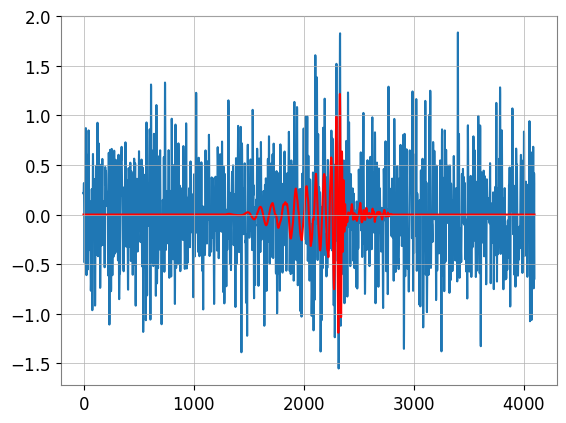

In [57]:
plt.plot(ruidos[0])
plt.plot(señales[0],color='red')

In [58]:
X_train, X_test, y_train, y_test = train_test_split(ruidos,señales,test_size=0.25,shuffle=True,random_state=42)

# Construimos el modelo

In [59]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * eps

In [160]:
latent_dim = 64

encoder_inputs = keras.Input(shape=(4096,1))
x = layers.Conv1D(32, 7, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv1D(64, 7, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1D(128, 7, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 4096, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 2048, 32)  │        256 │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 1024, 64)  │     14,400 │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 512, 128)  │     57,472 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 65536)     │          0 │ conv1d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │  4,194,368 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │  4,194,368 │ flatten_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,460,864 (32.28 MB)

 Trainable params: 8,460,864 (32.28 MB)

 Non-trainable params: 0 (0.00 B)

In [161]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(65536, activation="relu")(latent_inputs)
x = layers.Reshape((512, 128))(x)
x = layers.Conv1DTranspose(128, 7, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(64, 7, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(32, 7, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(1, 7, activation="linear", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 65536)          │     4,259,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 512, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_24             │ (None, 1024, 128)      │       114,816 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_25             │ (None, 2048, 64)       │        57,408 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_26             │ (None, 4096, 32)       │        14,368 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_27             │ (None, 4096, 1)        │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,446,657 (16.96 MB)

 Trainable params: 4,446,657 (16.96 MB)

 Non-trainable params: 0 (0.00 B)

In [162]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x_noisy,x_clean=data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x_noisy)
            z=sampling((z_mean,z_log_var))
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.square(x_clean - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + 0.001*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    

    def test_step(self, data):
        x_noisy,x_clean=data
        z_mean, z_log_var = self.encoder(x_noisy)
        z=sampling((z_mean,z_log_var))
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(tf.square(x_clean - reconstruction))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = reconstruction_loss + 0.001*kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }    
    
    def call(self, inputs):
        z = self.encoder(inputs)
        z=sampling(z)
        reconstructed = self.decoder(z)
        return reconstructed
    



In [63]:
BATCH_SIZE = 32
SHUFFLE_BUFFER = 1000

train_dataset = tf.data.Dataset.from_tensor_slices((X_train.astype(np.float32), y_train.astype(np.float32)))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [64]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test.astype(np.float32), y_test.astype(np.float32)))
test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [163]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
history=vae.fit(train_dataset, epochs=50, batch_size=250,validation_data=test_dataset,callbacks=[
        ReduceLROnPlateau(monitor='val_reconstruction_loss',patience=5,min_lr=1e-6),
        EarlyStopping(monitor="val_reconstruction_loss",mode='min', patience=10, restore_best_weights=True)
    ])

Epoch 1/50
 13/593 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - kl_loss: 7.9687e-04 - loss: 0.0180 - reconstruction_loss: 0.0180

2025-04-27 21:35:09.241321: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion', 12 bytes spill stores, 12 bytes spill loads



593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - kl_loss: 0.0365 - loss: 0.0163 - reconstruction_loss: 0.0163 - val_kl_loss: 0.4726 - val_loss: 0.0115 - val_reconstruction_loss: 0.0110 - learning_rate: 0.0010
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - kl_loss: 0.6482 - loss: 0.0088 - reconstruction_loss: 0.0082 - val_kl_loss: 0.7471 - val_loss: 0.0047 - val_reconstruction_loss: 0.0040 - learning_rate: 0.0010
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - kl_loss: 0.7776 - loss: 0.0041 - reconstruction_loss: 0.0033 - val_kl_loss: 0.7506 - val_loss: 0.0036 - val_reconstruction_loss: 0.0029 - learning_rate: 0.0010
Epoch 4/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - kl_loss: 0.7415 - loss: 0.0032 - reconstruction_loss: 0.0025 - val_kl_loss: 0.6070 - val_loss: 0.0034 - val_reconstruction_loss: 0.0028 - learning_rate: 0.0010
Epoch 5/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - kl_loss: 0.7203 - loss: 0.0028 - reconstruction_loss: 0.0021 - val_kl_loss: 0.7399 - val_loss: 

In [164]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']

In [165]:
reconstruction_loss=history.history['reconstruction_loss']
val_reconstruccion_loss=history.history['val_reconstruction_loss']

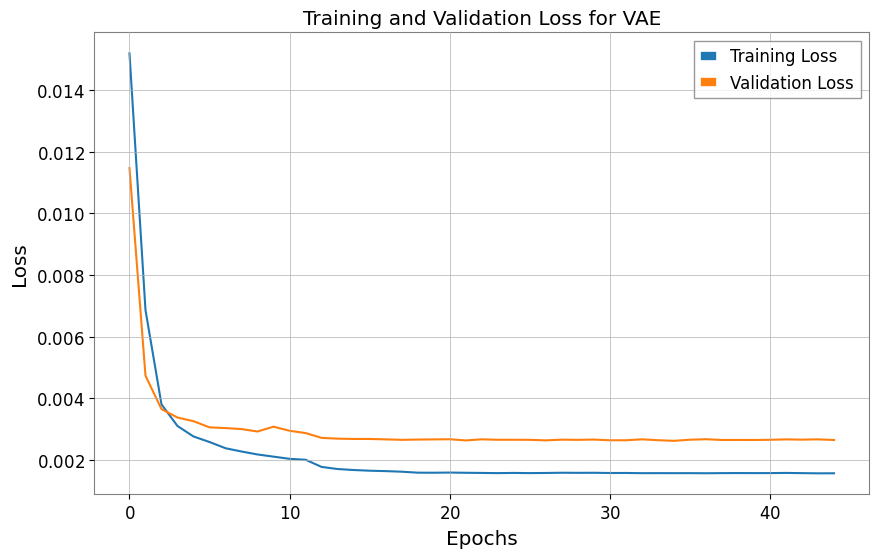

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for VAE')
plt.legend()
plt.grid(True)
plt.show()

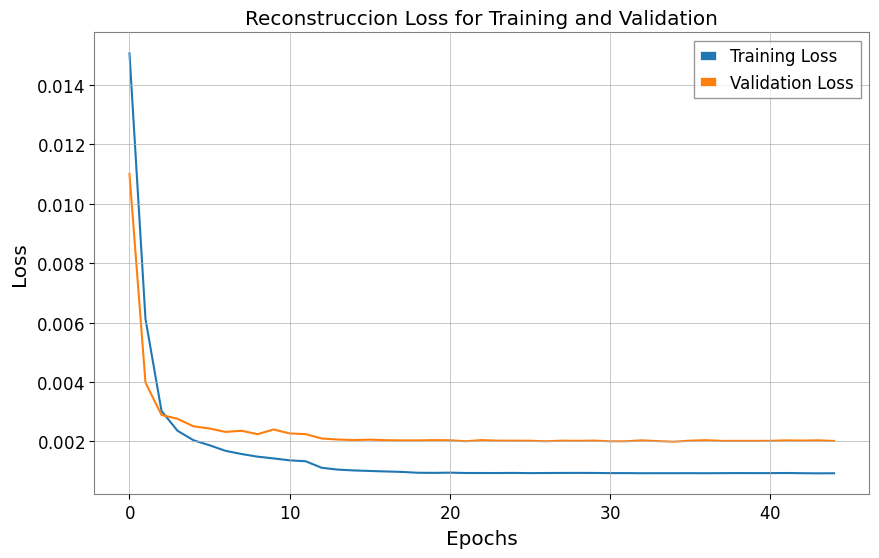

In [167]:
plt.figure(figsize=(10, 6))
plt.plot(reconstruction_loss, label='Training Loss')
plt.plot(val_reconstruccion_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Reconstruccion Loss for Training and Validation')
plt.legend()
plt.grid(True)
plt.show()

In [214]:
def predict(señal):
    señal=señal[np.newaxis,...,np.newaxis]
    z_mean, z_log_var= vae.encoder(señal)
    return vae.decoder(sampling((z_mean,z_log_var))).numpy().squeeze()

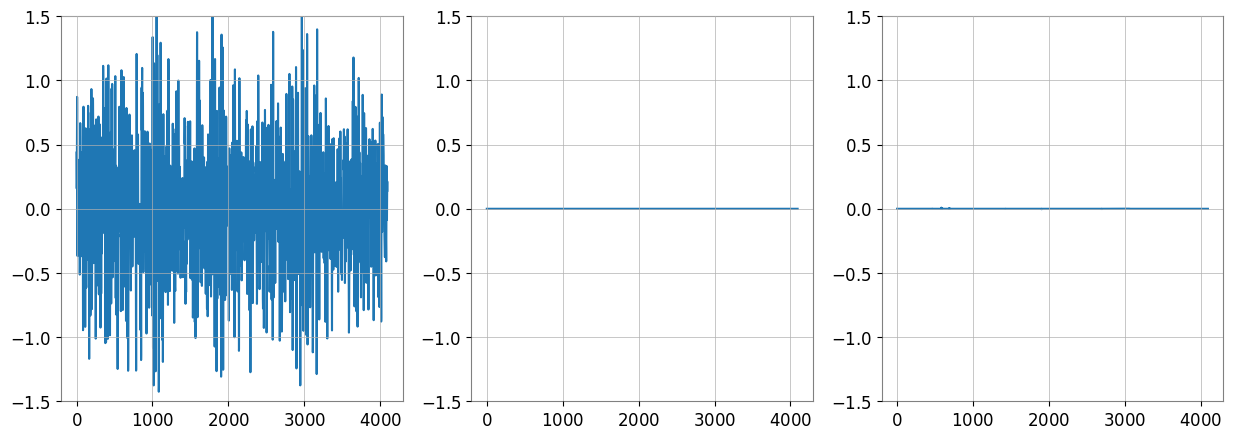

In [ ]:
index=0

fig,axes=plt.subplots(1,3,figsize=(15,5))
                    
axes[0].plot(X_test[index])
axes[1].plot(y_test[index])
axes[2].plot(predict(X_test[index]))

for ax in axes: ax.set_ylim(-1.5,1.5)


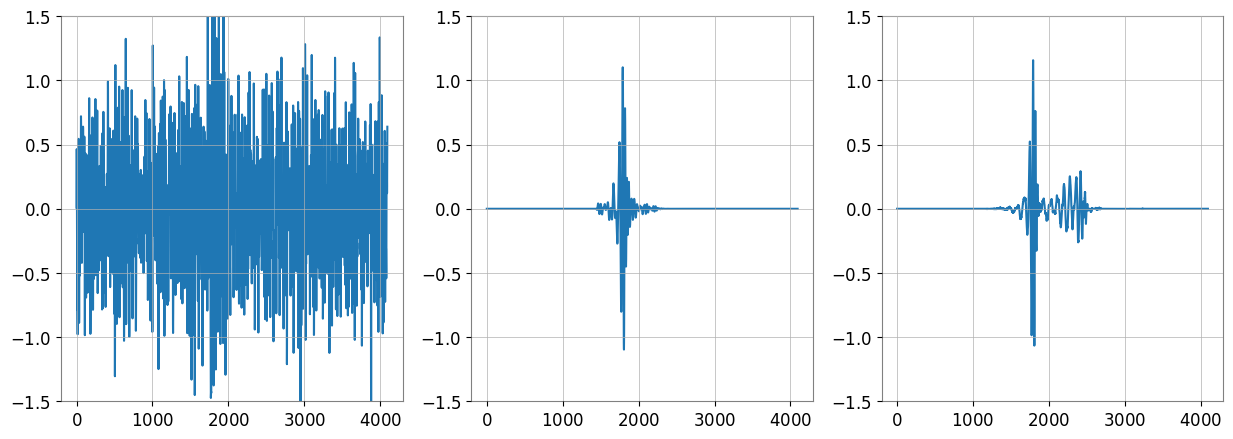

In [ ]:
index=1

fig,axes=plt.subplots(1,3,figsize=(15,5))
                    
axes[0].plot(X_test[index])
axes[1].plot(y_test[index])
axes[2].plot(predict(X_test[index]))

for ax in axes: ax.set_ylim(-1.5,1.5)

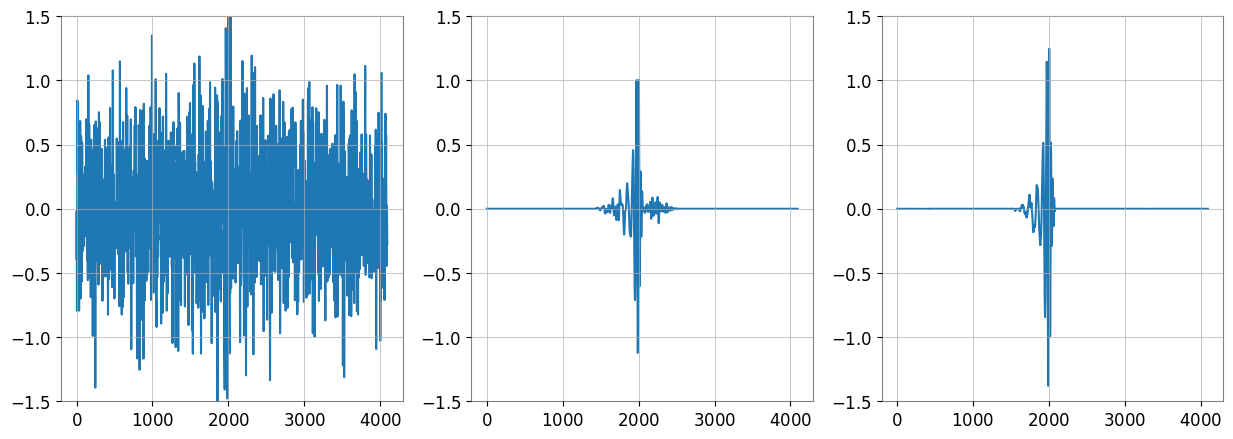

In [215]:
index=2

fig,axes=plt.subplots(1,3,figsize=(15,5))
                    
axes[0].plot(X_test[index])
axes[1].plot(y_test[index])
axes[2].plot(predict(X_test[index]))

for ax in axes: ax.set_ylim(-1.5,1.5)

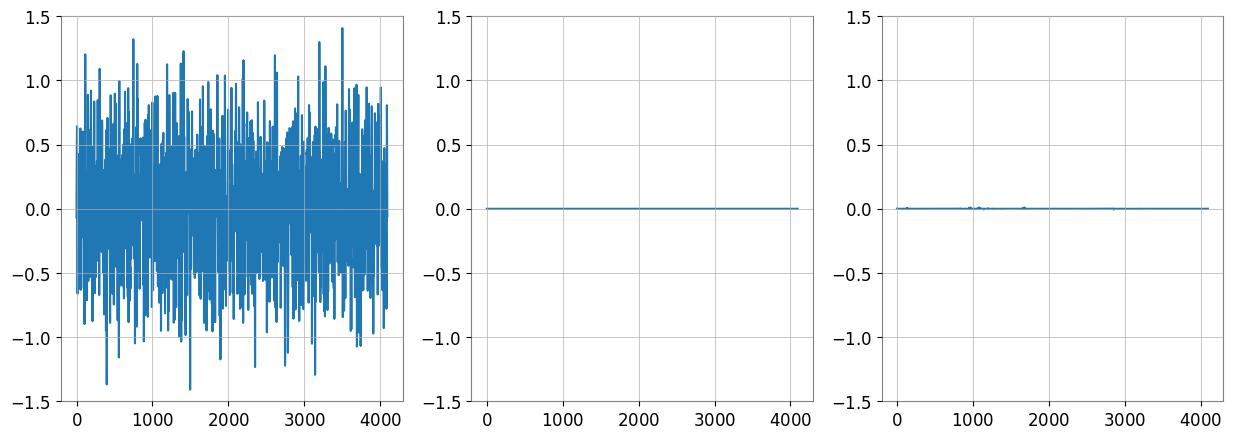

In [ ]:
index=3

fig,axes=plt.subplots(1,3,figsize=(15,5))
                    
axes[0].plot(X_test[index])
axes[1].plot(y_test[index])
axes[2].plot(predict(X_test[index]))

for ax in axes: ax.set_ylim(-1.5,1.5)

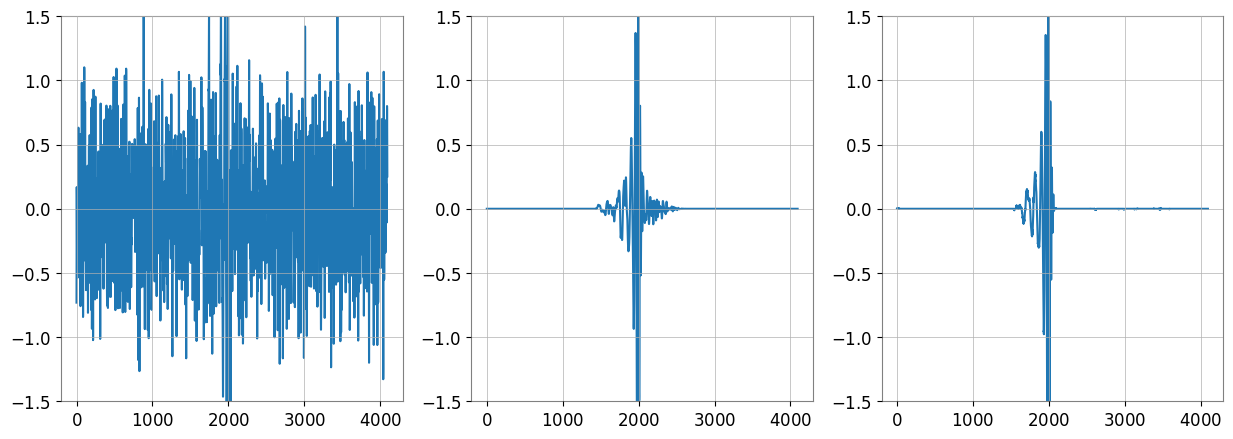

In [216]:
index=4

fig,axes=plt.subplots(1,3,figsize=(15,5))
                    
axes[0].plot(X_test[index])
axes[1].plot(y_test[index])
axes[2].plot(predict(X_test[index]))

for ax in axes: ax.set_ylim(-1.5,1.5)

In [300]:
def plot_real_examples(raw_data, output_data, titulo, limites, sample_rate=4096):


    time = np.linspace(0, raw_data.shape[0] / sample_rate, raw_data.shape[0])

    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
        
    axs[0].plot(time, raw_data, color='gray')
    axs[0].set_title(f'Evento: '+titulo)
    axs[0].set_ylabel('Amplitud')
    axs[0].set_xlim(limites[0],limites[1])

    axs[1].plot(time, output_data, color='blue')
    axs[1].set_title('Salida del VAE (Señal reconstruida)')
    axs[1].set_ylabel('Amplitud')
    axs[1].set_xlim(limites[0],limites[1])

    axs[2].plot(time, raw_data, color='gray')
    axs[2].plot(time, output_data, color='blue')
    axs[2].set_title('Señales superpuestas')
    axs[2].set_xlabel('Tiempo [s]')
    axs[2].set_ylabel('Amplitud')
    axs[2].set_xlim(limites[0],limites[1])



    plt.tight_layout()
    plt.show()

In [323]:
from gwpy.timeseries import TimeSeries as TS
from gwosc.datasets import event_gps

event = 'GW150914'
gps_time = event_gps(event)
segment = (gps_time - 4, gps_time +4)

# Obtener datos del detector Hanford (H1)
data = TS.fetch_open_data('H1', segment[0], segment[1], sample_rate=4096)

(1126259462.2, 1126259462.5)

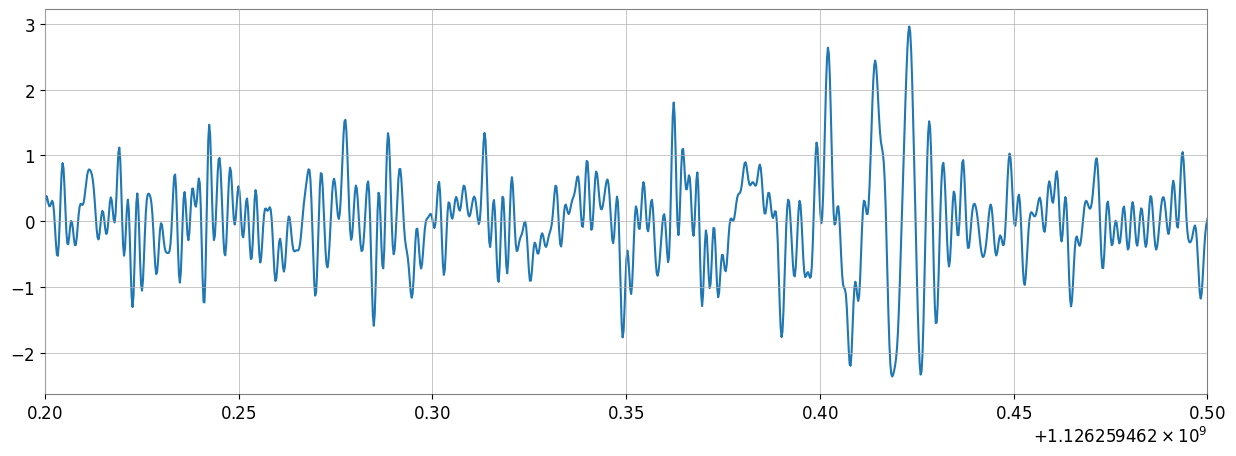

In [324]:
plt.figure(figsize=(15,5))
plt.plot(data.whiten().bandpass(20,500))
plt.xlim(gps_time-0.2,gps_time+0.1)


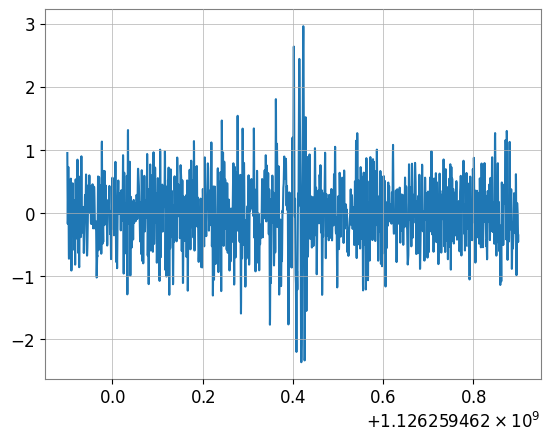

In [325]:
test_event=data.whiten().bandpass(20.0,500.0)[4*4096-2048:4*4096+2048]

plt.plot(test_event)

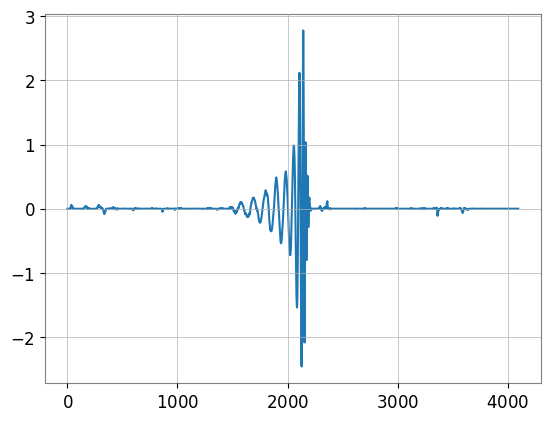

In [326]:
z_mean, z_log_var= vae.encoder(test_event[np.newaxis,...,np.newaxis])
denoised=vae.decoder(sampling((z_mean,z_log_var))).numpy().squeeze()

plt.plot(denoised)

(1600.0, 2300.0)

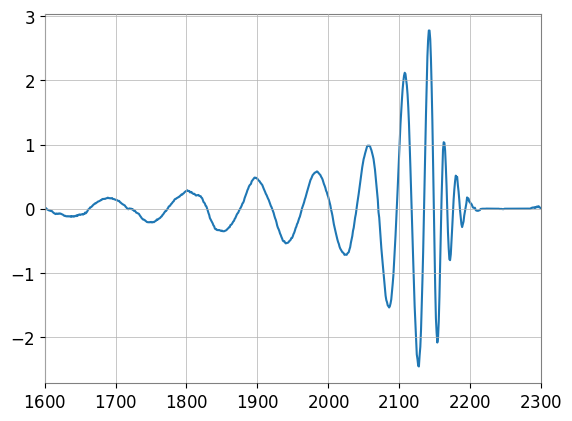

In [327]:
plt.plot(denoised)
plt.xlim(1600,2300)

(1600.0, 2300.0)

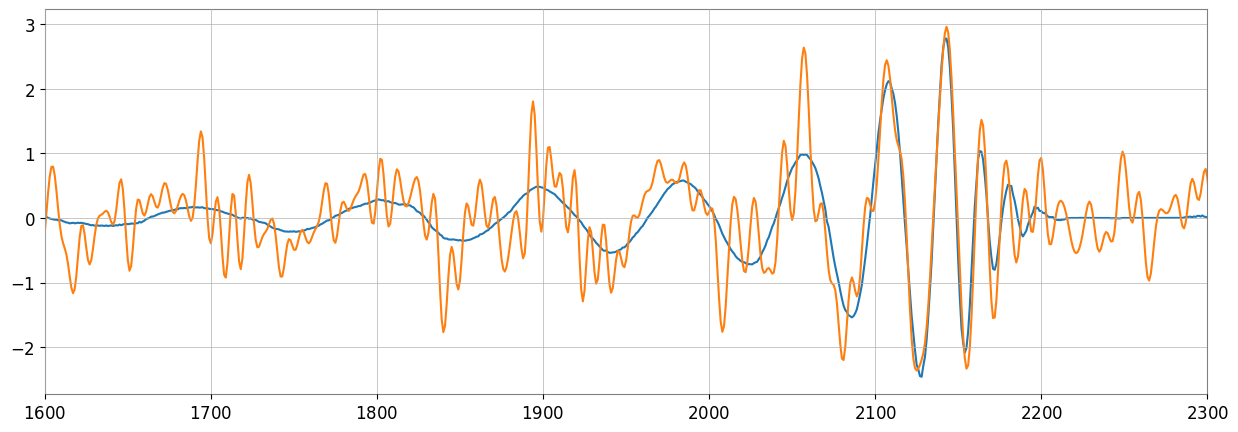

In [328]:
plt.figure(figsize=(15,5))
plt.plot(denoised)
plt.plot(np.array(test_event))
plt.xlim(1600,2300)


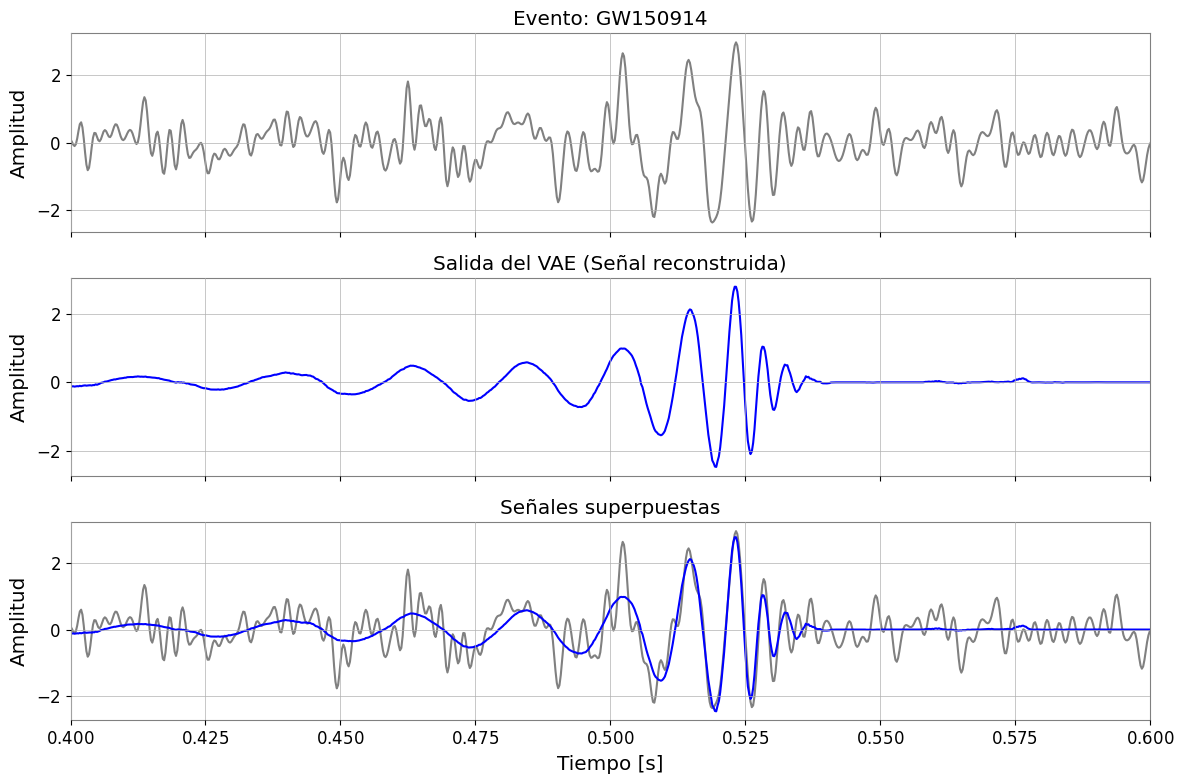

In [329]:
plot_real_examples(test_event,denoised,'GW150914',(0.4,0.6))

(1186741861.3, 1186741861.6)

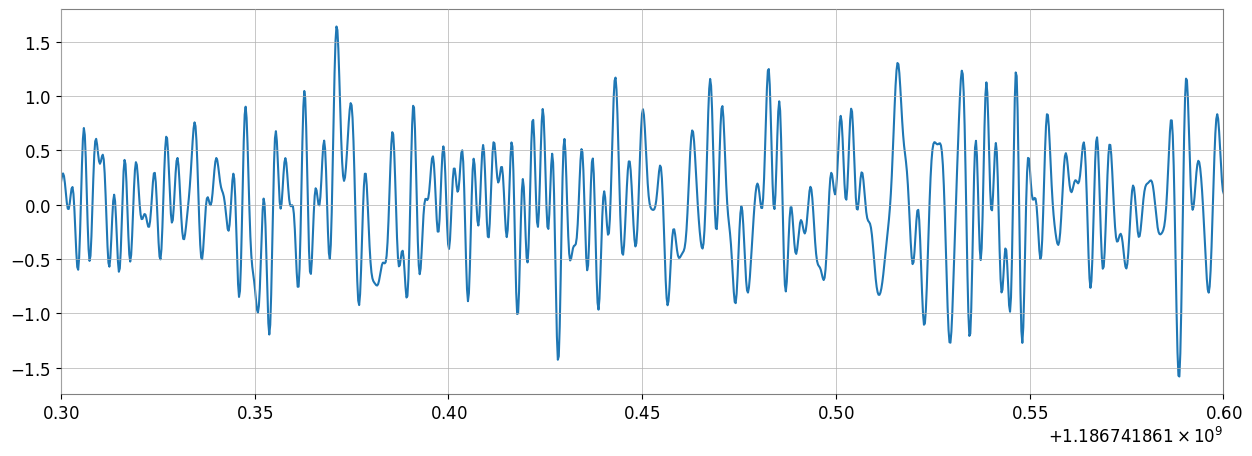

In [330]:
event = 'GW170814'
gps_time = event_gps(event)
segment = (gps_time - 4, gps_time +4)

# Obtener datos del detector Hanford (H1)
data = TS.fetch_open_data('H1', segment[0], segment[1], sample_rate=4096)

plt.figure(figsize=(15,5))
plt.plot(data.whiten().bandpass(20,400))
plt.xlim(gps_time-0.2,gps_time+0.1)

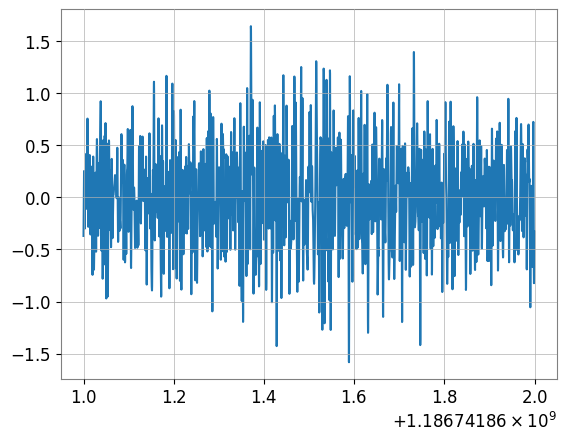

In [331]:
test_event=data.whiten().bandpass(20.0,400.0)[4*4096-2048:4*4096+2048]

plt.plot(test_event)

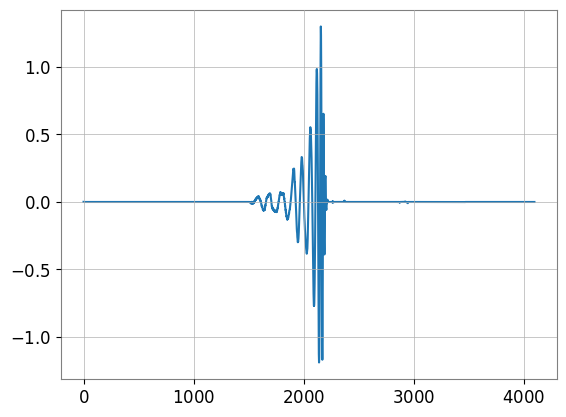

In [332]:
z_mean, z_log_var= vae.encoder(test_event[np.newaxis,...,np.newaxis])
denoised=vae.decoder(sampling((z_mean,z_log_var))).numpy().squeeze()

plt.plot(denoised)

(1500.0, 2500.0)

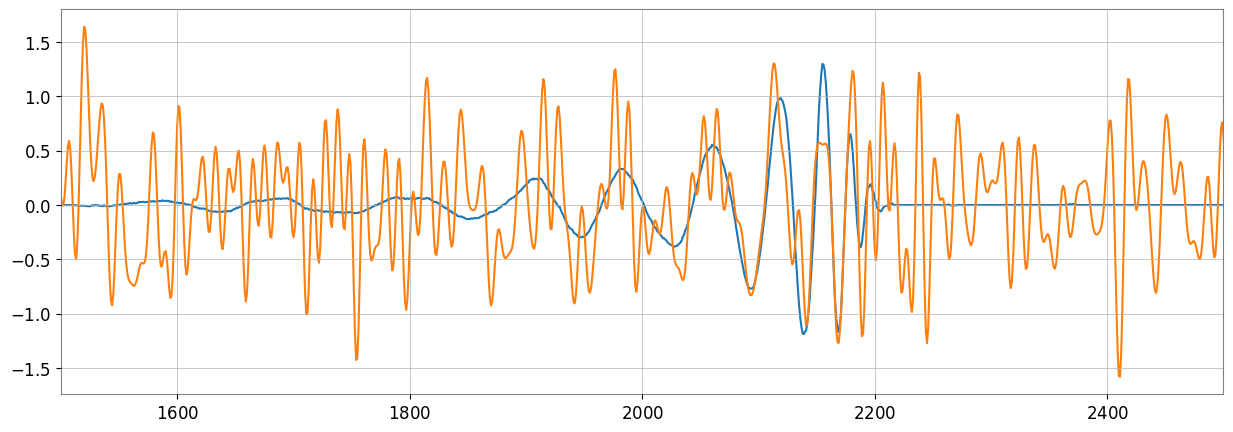

In [333]:
plt.figure(figsize=(15,5))
plt.plot(denoised)
plt.plot(np.array(test_event))
plt.xlim(1500,2500)

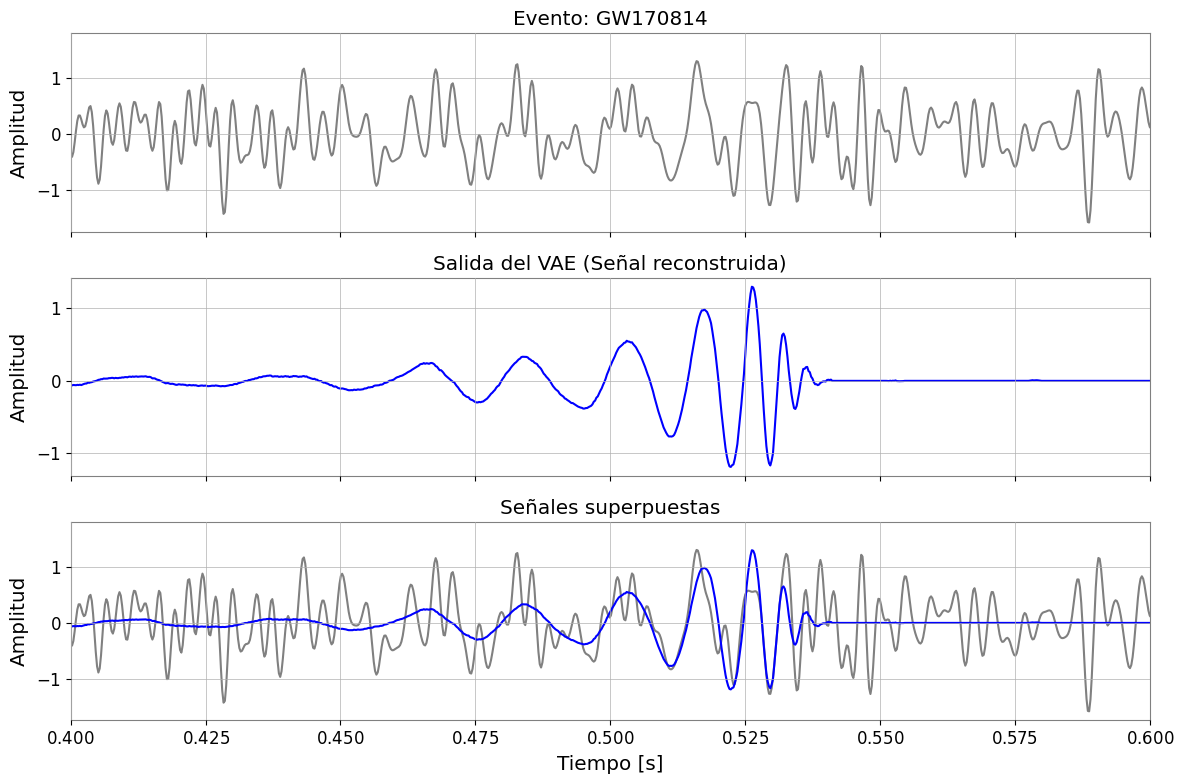

In [334]:
plot_real_examples(test_event,denoised,'GW170814',(0.4,0.6))

(1187529256.3, 1187529256.6)

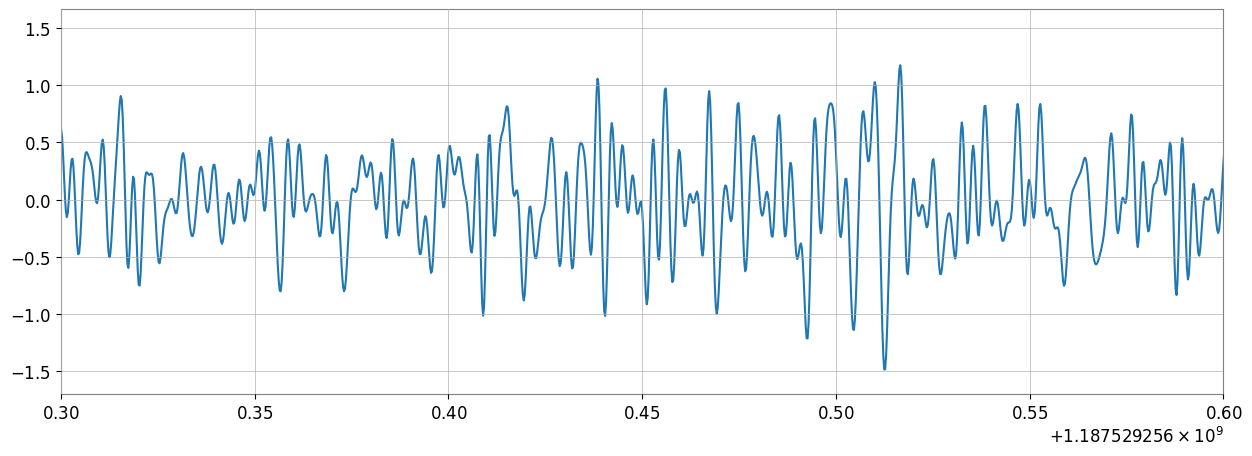

In [335]:
event = 'GW170823'
gps_time = event_gps(event)
segment = (gps_time - 4, gps_time +4)

# Obtener datos del detector Hanford (H1)
data = TS.fetch_open_data('H1', segment[0], segment[1], sample_rate=4096)

plt.figure(figsize=(15,5))
plt.plot(data.whiten().bandpass(20,400))
plt.xlim(gps_time-0.2,gps_time+0.1)

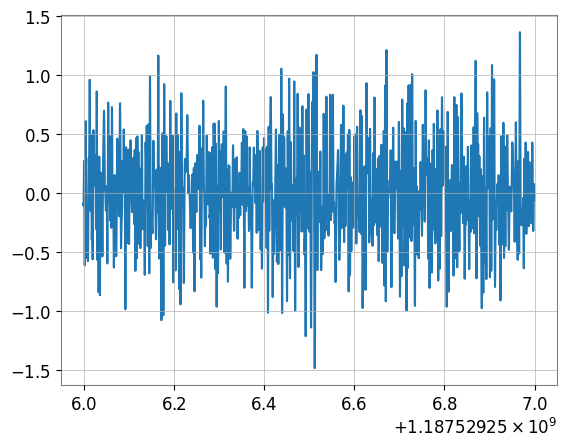

In [336]:
test_event=data.whiten().bandpass(20.0,400.0)[4*4096-2048:4*4096+2048]

plt.plot(test_event)

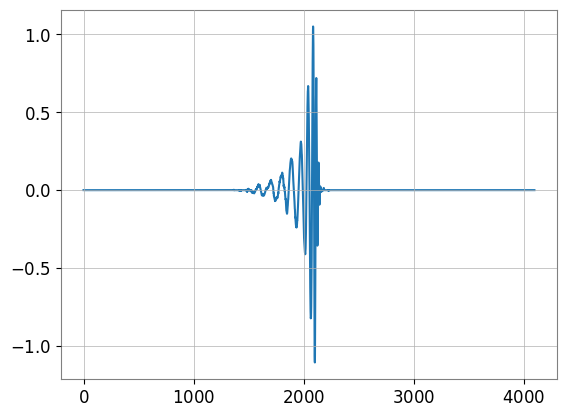

In [337]:
z_mean, z_log_var= vae.encoder(test_event[np.newaxis,...,np.newaxis])
denoised=vae.decoder(sampling((z_mean,z_log_var))).numpy().squeeze()

plt.plot(denoised)

(1600.0, 2300.0)

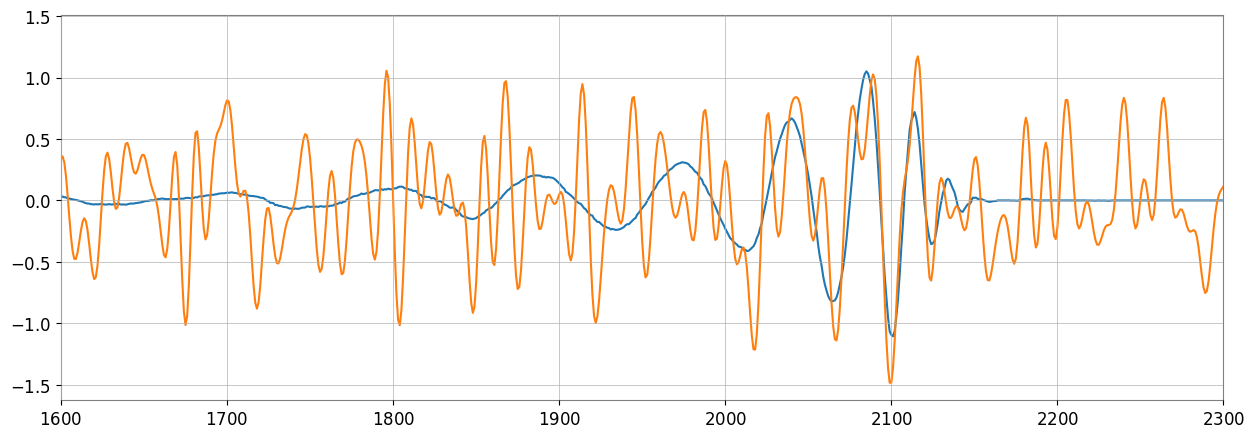

In [338]:
plt.figure(figsize=(15,5))
plt.plot(denoised)
plt.plot(np.array(test_event))
plt.xlim(1600,2300)

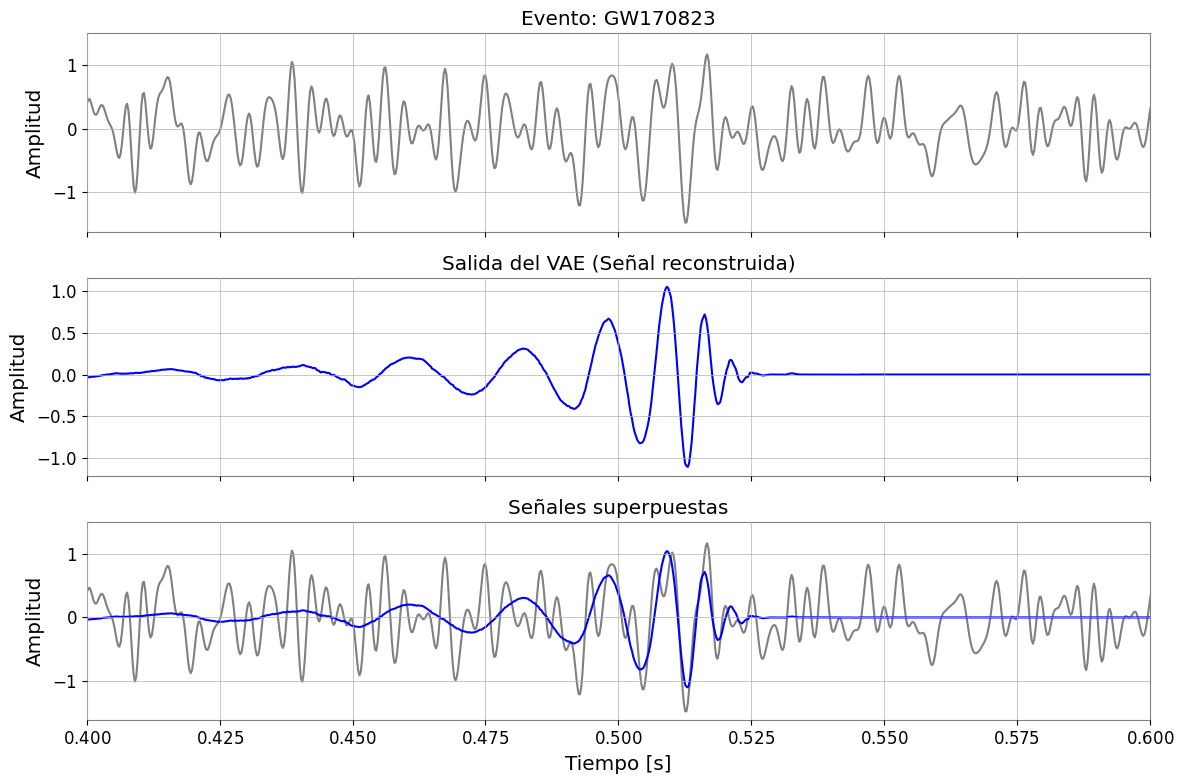

In [339]:
plot_real_examples(test_event,denoised,'GW170823',(0.4,0.6))

(1242459857.2, 1242459857.5)

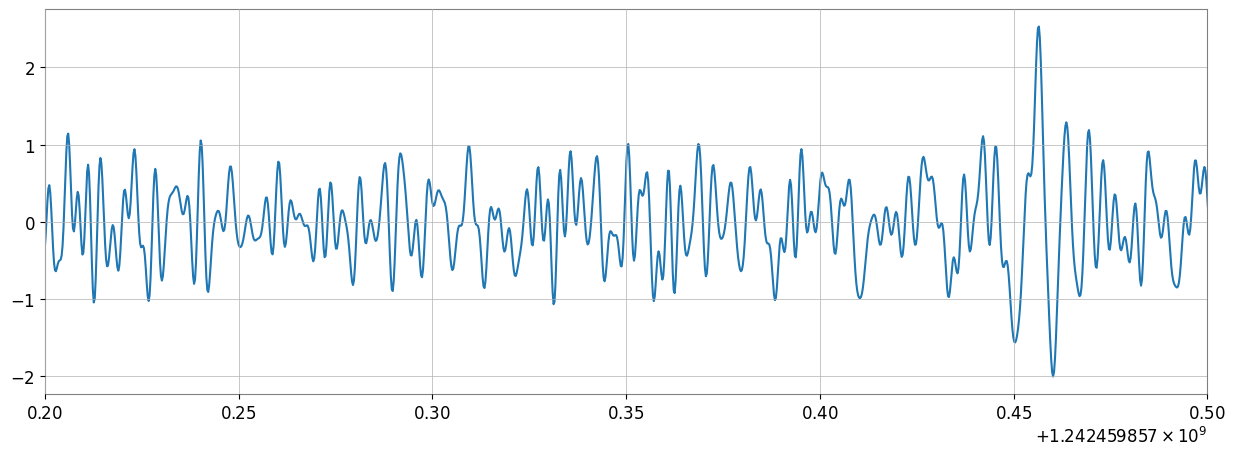

In [340]:
event = 'GW190521'
gps_time=1242459857.4
segment = (gps_time - 4, gps_time +4)

# Obtener datos del detector Hanford (H1)
data = TS.fetch_open_data('H1', segment[0], segment[1], sample_rate=4096)

plt.figure(figsize=(15,5))
plt.plot(data.whiten().bandpass(20,400))
plt.xlim(gps_time-0.2,gps_time+0.1)

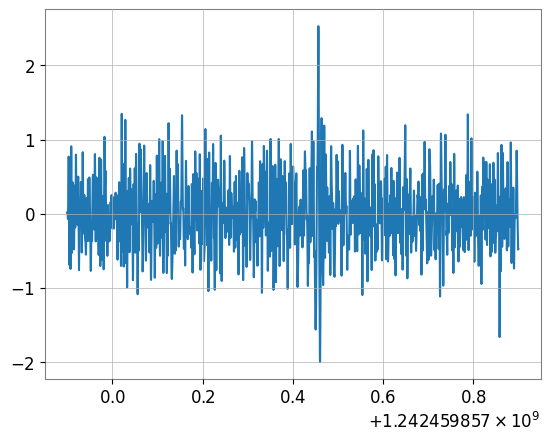

In [341]:
test_event=data.whiten().bandpass(20.0,400.0)[4*4096-2048:4*4096+2048]

plt.plot(test_event)

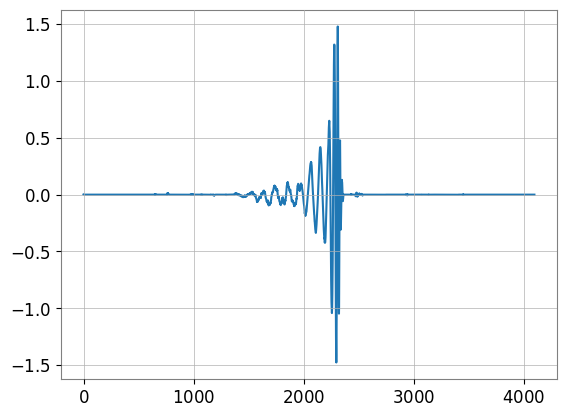

In [342]:
z_mean, z_log_var= vae.encoder(test_event[np.newaxis,...,np.newaxis])
denoised=vae.decoder(sampling((z_mean,z_log_var))).numpy().squeeze()

plt.plot(denoised)

(1600.0, 2500.0)

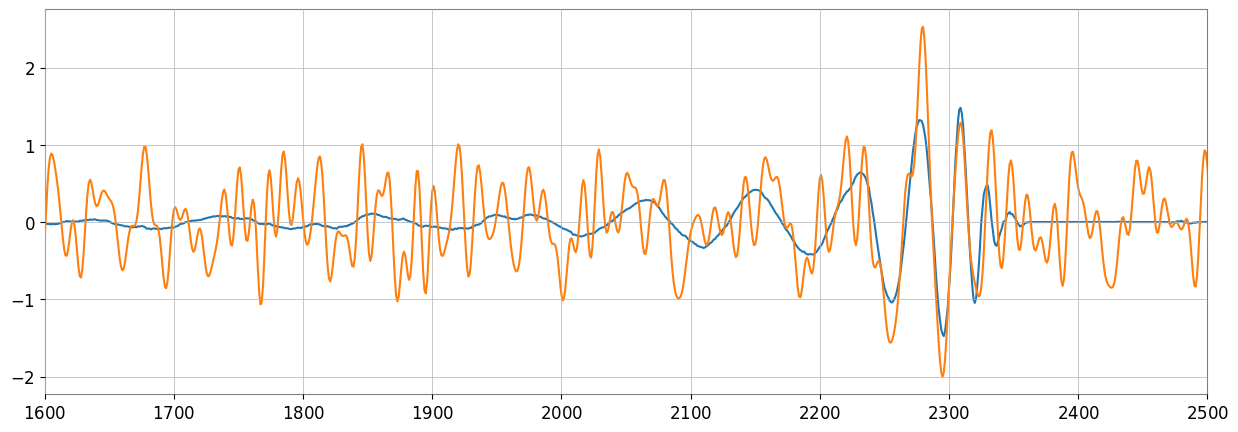

In [343]:
plt.figure(figsize=(15,5))
plt.plot(denoised)
plt.plot(np.array(test_event))
plt.xlim(1600,2500)

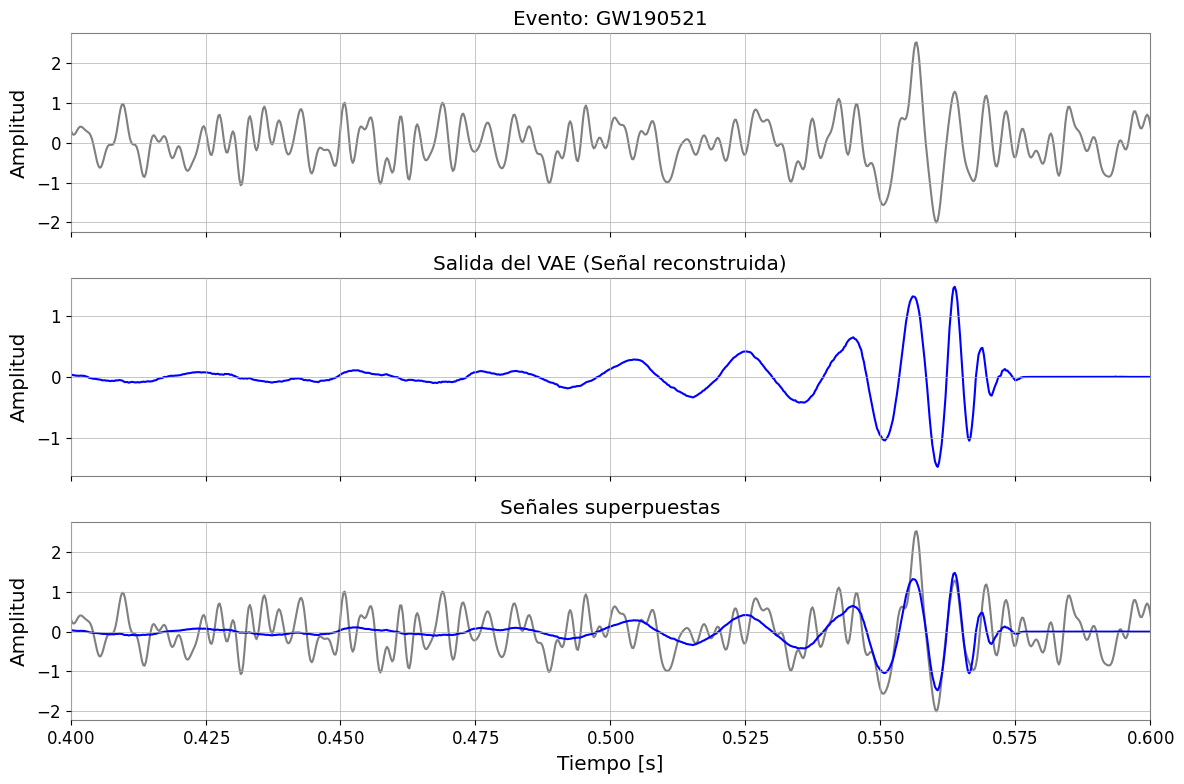

In [344]:
plot_real_examples(test_event,denoised,'GW190521',(0.4,0.6))

In [ ]:
corr, _ = pearsonr(predict(X_test[2]), y_test[2].squeeze())
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.967


In [232]:
X_test.shape

(6316, 4096, 1)

In [261]:
correlations=[pearsonr(predict(X_test[index]),y_test[index].squeeze())[0] for index in range(X_test.shape[0])]

/tmp/ipykernel_132449/3988445722.py:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlations=[pearsonr(predict(X_test[index]),y_test[index].squeeze())[0] for index in range(X_test.shape[0])]


In [262]:
mean_correlation=np.mean(np.array(correlations)[~np.isnan(correlations).squeeze()])

In [263]:
mean_correlation

np.float64(0.8802159024998494)

In [278]:

def plot_validation_examples(input_data, output_data, target_data, indices=None, sample_rate=4096):

    if indices is None:
        indices = np.random.choice(len(input_data), size=5, replace=False)

    time = np.linspace(0, input_data.shape[1] / sample_rate, input_data.shape[1])

    for idx in indices:
        fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
        
        axs[0].plot(time, input_data[idx], color='gray')
        axs[0].set_title(f'Entrada (Ruido + Señal) - Ejemplo {idx}')
        axs[0].set_ylabel('Amplitud')
        axs[0].set_ylim(-2,2)

        axs[1].plot(time, output_data[idx], color='blue')
        axs[1].set_title('Salida del VAE (Señal reconstruida)')
        axs[1].set_ylabel('Amplitud')
        axs[1].set_ylim(-2,2)

        axs[2].plot(time, target_data[idx], color='green')
        axs[2].set_title('Señal inyectada (Target)')
        axs[2].set_xlabel('Tiempo [s]')
        axs[2].set_ylabel('Amplitud')
        axs[2].set_ylim(-2,2)

        plt.ylim(-2,2)

        plt.tight_layout()
        plt.show()

In [267]:
predicciones=[predict(señal) for señal in X_test]

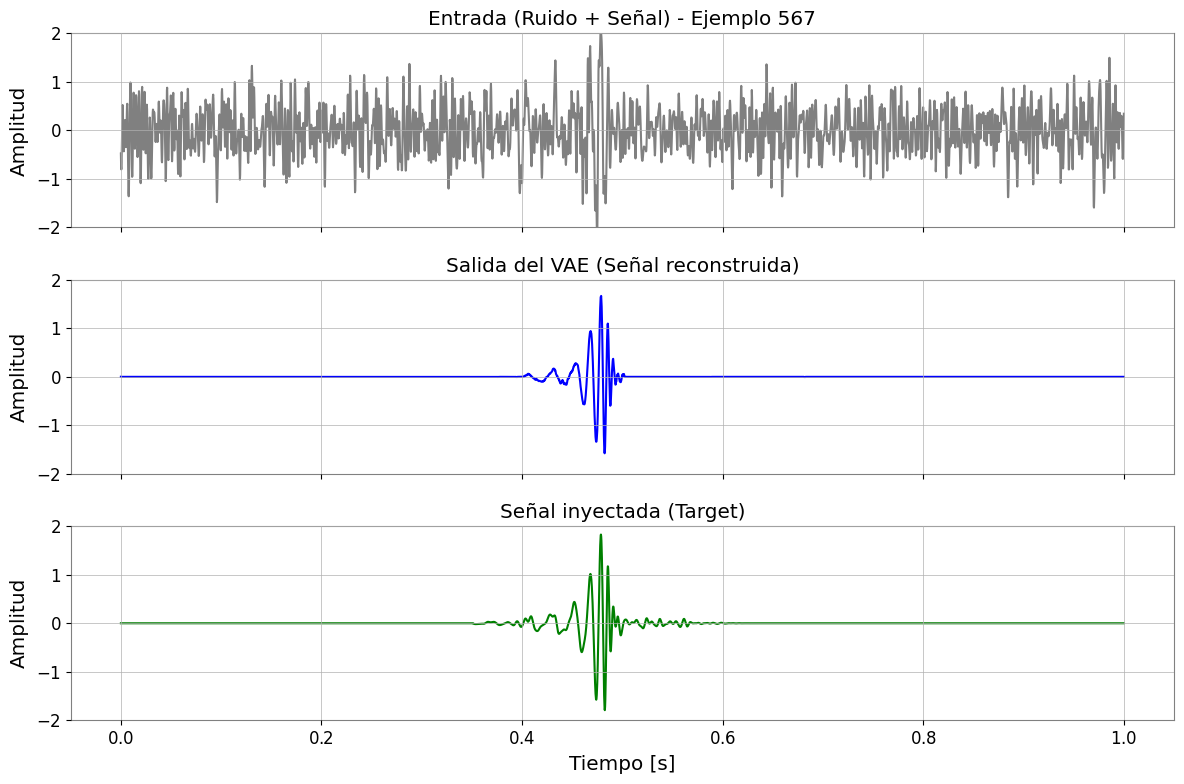

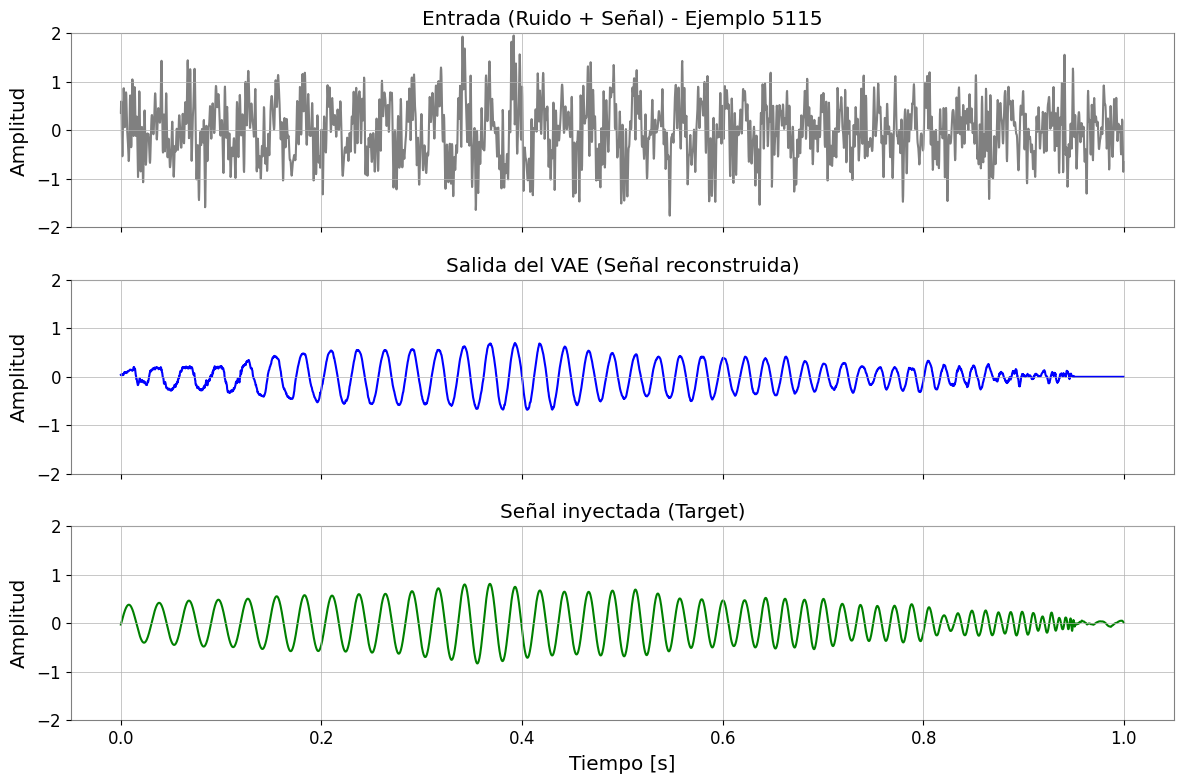

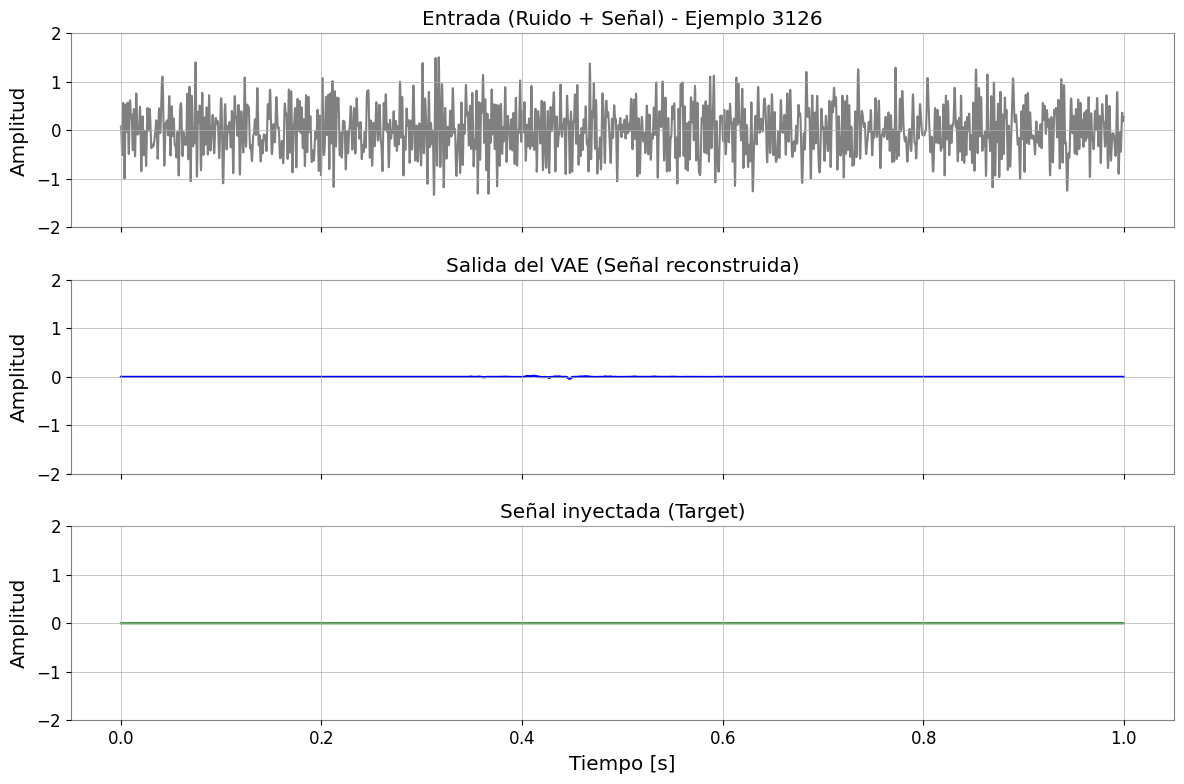

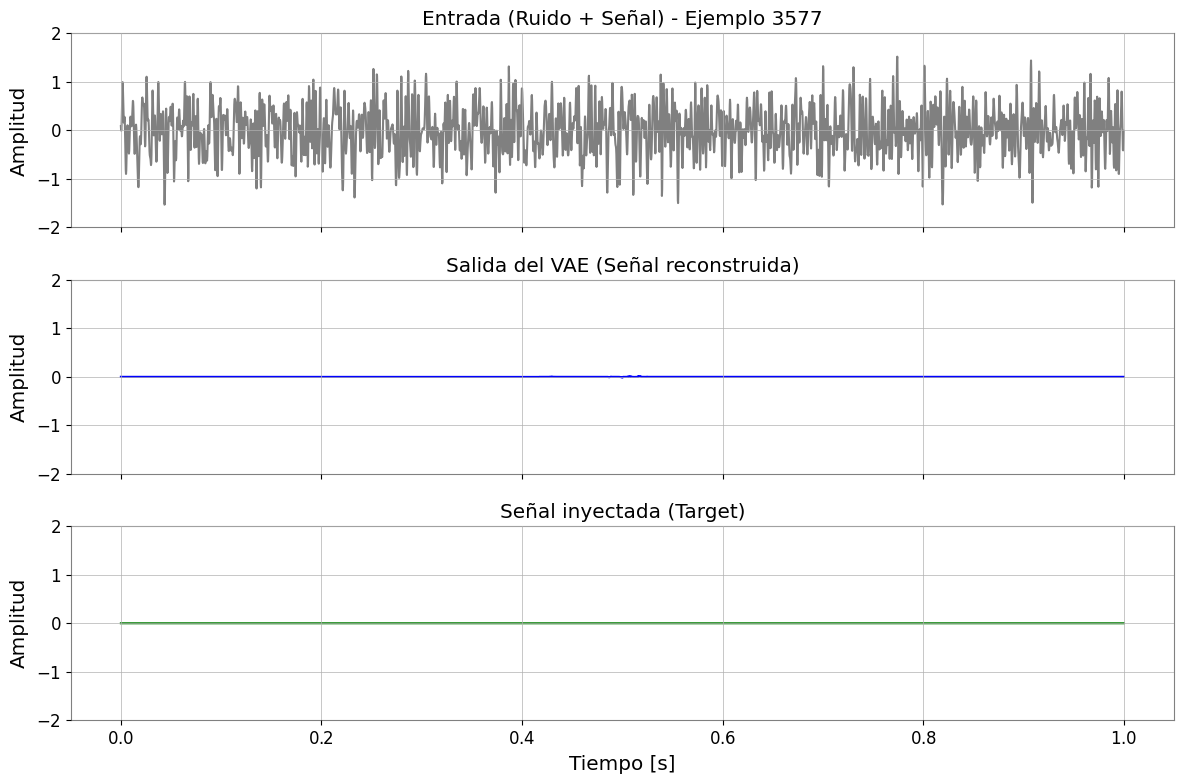

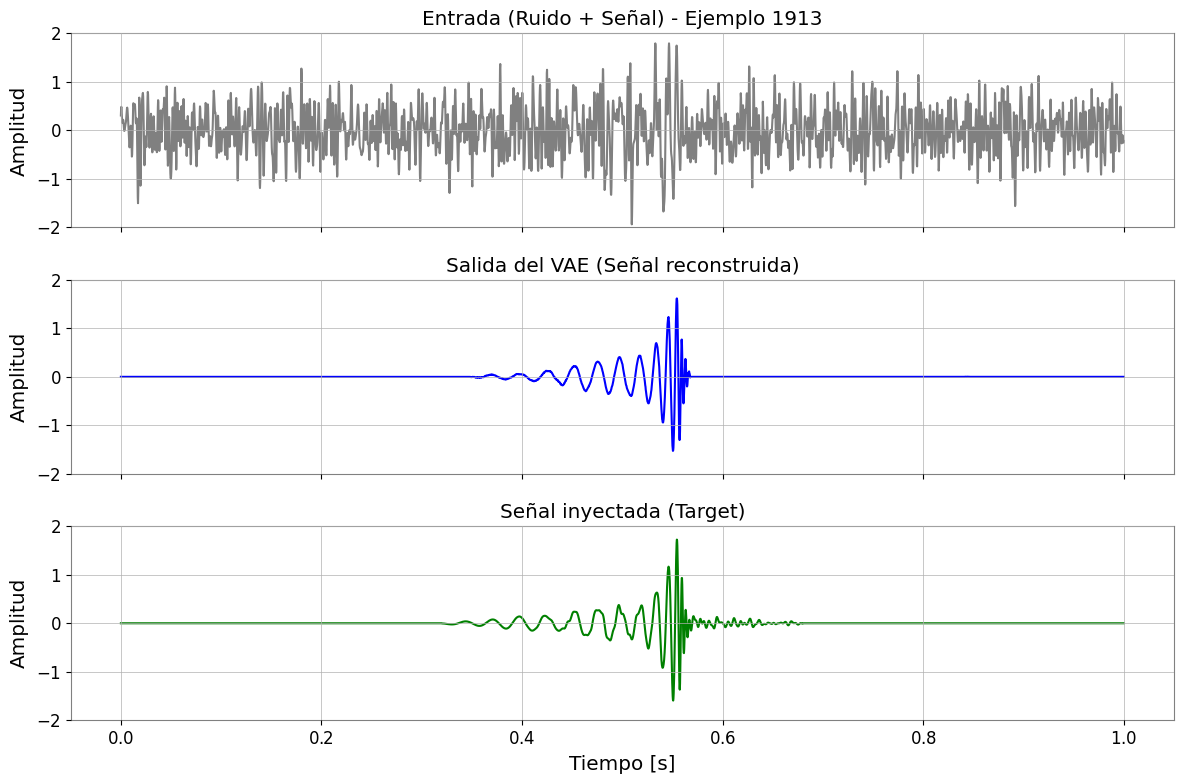

In [280]:
plot_validation_examples(X_test,predicciones,y_test)